# Facial Emotion Recognition Using Machine Learning Methods

In [1]:
import os

from platform import python_version
import warnings
import time
import datetime as dt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import multiprocessing as mp
import shutil
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input, decode_predictions
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras import regularizers

import pandas as pd
import numpy as np
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from PIL import Image
import xml.etree.ElementTree as ET
import psutil
import random

warnings.filterwarnings("ignore")
%matplotlib inline

ModuleNotFoundError: No module named 'sklearn'

## Data Preprocessing

In [2]:
DATADIR = r'/kaggle/input/ck-dataset'
CATEGORIES = os.listdir(DATADIR)
CATEGORIES

['surprise', 'fear', 'sadness', 'disgust', 'contempt', 'happy', 'anger']

In [3]:
def load_data():
    data = []
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        
        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path, img), 0)
            data.append([img_array, class_num])
    return data

data = load_data()

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 135/135 [00:00<00:00, 343.81it/s]


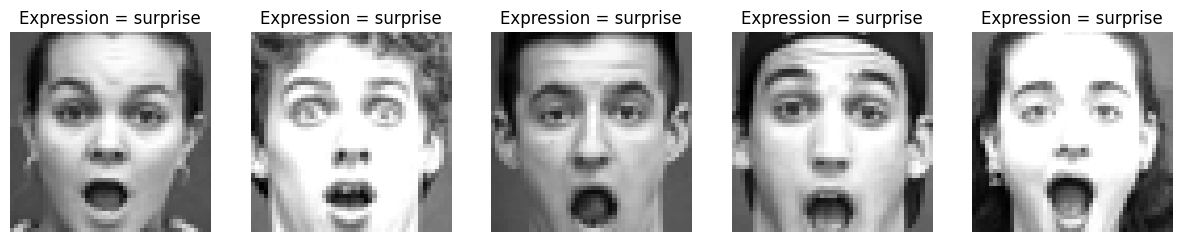

In [4]:
samples = data[0:5]

fig, axes = plt.subplots(1, len(samples), figsize=(15,5))

for i, sample in enumerate(samples):
    img = sample[0]      
    label = sample[1]   
    axes[i].set_title("Expression = " + str(CATEGORIES[label]))
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')

plt.show()

In [5]:
import os
import cv2
import numpy as np
import random
from tqdm import tqdm
from skimage.feature import hog
import dlib
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report


DATADIR = r'/kaggle/input/ck-dataset'
CATEGORIES = os.listdir(DATADIR)
IMG_SIZE = 64  

# -------------------------------
# Thi·∫øt l·∫≠p face detector v√† predictor (cho face alignment)
# -------------------------------
predictor_path = "/kaggle/input/shape-predictor-68-face-landmarks/shape_predictor_68_face_landmarks.dat"
if os.path.exists(predictor_path):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(predictor_path)
    use_alignment = True
    print("Face alignment s·∫Ω ƒë∆∞·ª£c s·ª≠ d·ª•ng.")
else:
    print("Warning: Kh√¥ng t√¨m th·∫•y file shape_predictor_68_face_landmarks.dat. B·ªè qua face alignment.")
    use_alignment = False

def enhance_image(img):
    """
    Histogram equalization l√† m·ªôt k·ªπ thu·∫≠t x·ª≠ l√Ω ·∫£nh nh·∫±m c·∫£i thi·ªán ƒë·ªô t∆∞∆°ng ph·∫£n b·∫±ng c√°ch ph√¢n b·ªë l·∫°i 
    c√°c gi√° tr·ªã pixel sao cho histogram c·ªßa ·∫£nh ƒë∆∞·ª£c tr·∫£i ƒë·ªÅu h∆°n. K·ªπ thu·∫≠t n√†y gi√∫p l√†m n·ªïi b·∫≠t c√°c chi ti·∫øt 
    quan tr·ªçng trong ·∫£nh, ƒë·∫∑c bi·ªát h·ªØu √≠ch khi ·∫£nh c√≥ c√°c v√πng qu√° t·ªëi ho·∫∑c qu√° s√°ng.

    Steps:
        1. Nh·∫≠n ·∫£nh ƒë·∫ßu v√†o d·∫°ng grayscale d∆∞·ªõi d·∫°ng m·∫£ng NumPy.
        2. S·ª≠ d·ª•ng cv2.equalizeHist ƒë·ªÉ √°p d·ª•ng histogram equalization.
        3. Tr·∫£ v·ªÅ ·∫£nh sau khi ƒë∆∞·ª£c tƒÉng c∆∞·ªùng.

    Parameters:
        img (numpy.ndarray): ·∫¢nh ƒë·∫ßu v√†o ·ªü d·∫°ng grayscale (m·∫£ng 2 chi·ªÅu).

    Returns:
        numpy.ndarray: ·∫¢nh ƒë√£ ƒë∆∞·ª£c x·ª≠ l√Ω, v·ªõi ƒë·ªô t∆∞∆°ng ph·∫£n ƒë∆∞·ª£c c·∫£i thi·ªán.
    """
    return cv2.equalizeHist(img)

def align_face(img):
    """
    Th·ª±c hi·ªán canh ch·ªânh khu√¥n m·∫∑t trong ·∫£nh b·∫±ng c√°ch s·ª≠ d·ª•ng th∆∞ vi·ªán dlib.

    Quy tr√¨nh:
        1. Ph√°t hi·ªán khu√¥n m·∫∑t trong ·∫£nh s·ª≠ d·ª•ng detector c·ªßa dlib.
        2. N·∫øu c√≥ khu√¥n m·∫∑t, d·ª± ƒëo√°n 68 ƒëi·ªÉm landmark c·ªßa khu√¥n m·∫∑t ƒë√≥.
        3. T√≠nh v·ªã tr√≠ trung b√¨nh c·ªßa m·∫Øt tr√°i v√† m·∫Øt ph·∫£i t·ª´ c√°c landmark t∆∞∆°ng ·ª©ng.
        4. T√≠nh g√≥c gi·ªØa ƒë∆∞·ªùng n·ªëi hai m·∫Øt v√† xoay ·∫£nh sao cho ƒë∆∞·ªùng n·ªëi n√†y n·∫±m ngang.
        5. Tr·∫£ v·ªÅ ·∫£nh ƒë√£ ƒë∆∞·ª£c xoay (canh ch·ªânh).
        6. N·∫øu kh√¥ng ph√°t hi·ªán ƒë∆∞·ª£c khu√¥n m·∫∑t, tr·∫£ v·ªÅ ·∫£nh g·ªëc.

    Parameters:
        img (numpy.ndarray): ·∫¢nh ƒë·∫ßu v√†o d·∫°ng grayscale.

    Returns:
        numpy.ndarray: ·∫¢nh ƒë√£ ƒë∆∞·ª£c canh ch·ªânh (n·∫øu khu√¥n m·∫∑t ƒë∆∞·ª£c ph√°t hi·ªán) ho·∫∑c ·∫£nh g·ªëc n·∫øu kh√¥ng th·ªÉ canh ch·ªânh.
    """
    rects = detector(img, 1)
    if len(rects) == 0:
        return img
    rect = rects[0]
    shape = predictor(img, rect)
    landmarks = np.array([[p.x, p.y] for p in shape.parts()])
    left_eye_pts = landmarks[36:42]
    right_eye_pts = landmarks[42:48]
    left_eye_center = left_eye_pts.mean(axis=0).astype(int)
    right_eye_center = right_eye_pts.mean(axis=0).astype(int)
    eyes_center = (int((left_eye_center[0] + right_eye_center[0]) / 2),
                   int((left_eye_center[1] + right_eye_center[1]) / 2))
    dY = right_eye_center[1] - left_eye_center[1]
    dX = right_eye_center[0] - left_eye_center[0]
    angle = np.degrees(np.arctan2(dY, dX))
    M = cv2.getRotationMatrix2D(eyes_center, angle, 1)
    aligned_img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_CUBIC)
    return aligned_img

def preprocess_image(img_path):
    """
    Th·ª±c hi·ªán ti·ªÅn x·ª≠ l√Ω cho ·∫£nh d·ª±a tr√™n ƒë∆∞·ªùng d·∫´n ƒë·∫øn ·∫£nh.

    Quy tr√¨nh ti·ªÅn x·ª≠ l√Ω bao g·ªìm:
        1. ƒê·ªçc ·∫£nh ·ªü d·∫°ng grayscale.
        2. TƒÉng c∆∞·ªùng ·∫£nh b·∫±ng histogram equalization.
        3. N·∫øu ƒë∆∞·ª£c thi·∫øt l·∫≠p s·ª≠ d·ª•ng face alignment, canh ch·ªânh khu√¥n m·∫∑t.
        4. Resize ·∫£nh v·ªÅ k√≠ch th∆∞·ªõc chu·∫©n (v√≠ d·ª•: 64x64).

    Parameters:
        img_path (str): ƒê∆∞·ªùng d·∫´n ƒë·∫øn ·∫£nh.

    Returns:
        numpy.ndarray: ·∫¢nh ƒë√£ ƒë∆∞·ª£c ti·ªÅn x·ª≠ l√Ω.
                        N·∫øu kh√¥ng ƒë·ªçc ƒë∆∞·ª£c ·∫£nh, tr·∫£ v·ªÅ None.
    """
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    enhanced = enhance_image(img)
    if use_alignment:
        aligned = align_face(enhanced)
    else:
        aligned = enhanced
    resized = cv2.resize(aligned, (IMG_SIZE, IMG_SIZE))
    return resized

def load_data():
    data = []
    labels = []
    for cat in CATEGORIES:
        path = os.path.join(DATADIR, cat)
        label = CATEGORIES.index(cat)
        for file in tqdm(os.listdir(path), desc=f"Processing {cat}"):
            img_path = os.path.join(path, file)
            processed = preprocess_image(img_path)
            if processed is not None:
                data.append(processed)
                labels.append(label)
    return np.array(data), np.array(labels)

print("Loading v√† ti·ªÅn x·ª≠ l√Ω d·ªØ li·ªáu...")
images, labels = load_data()

Face alignment s·∫Ω ƒë∆∞·ª£c s·ª≠ d·ª•ng.
Loading v√† ti·ªÅn x·ª≠ l√Ω d·ªØ li·ªáu...


Processing anger: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 135/135 [00:00<00:00, 148.50it/s]


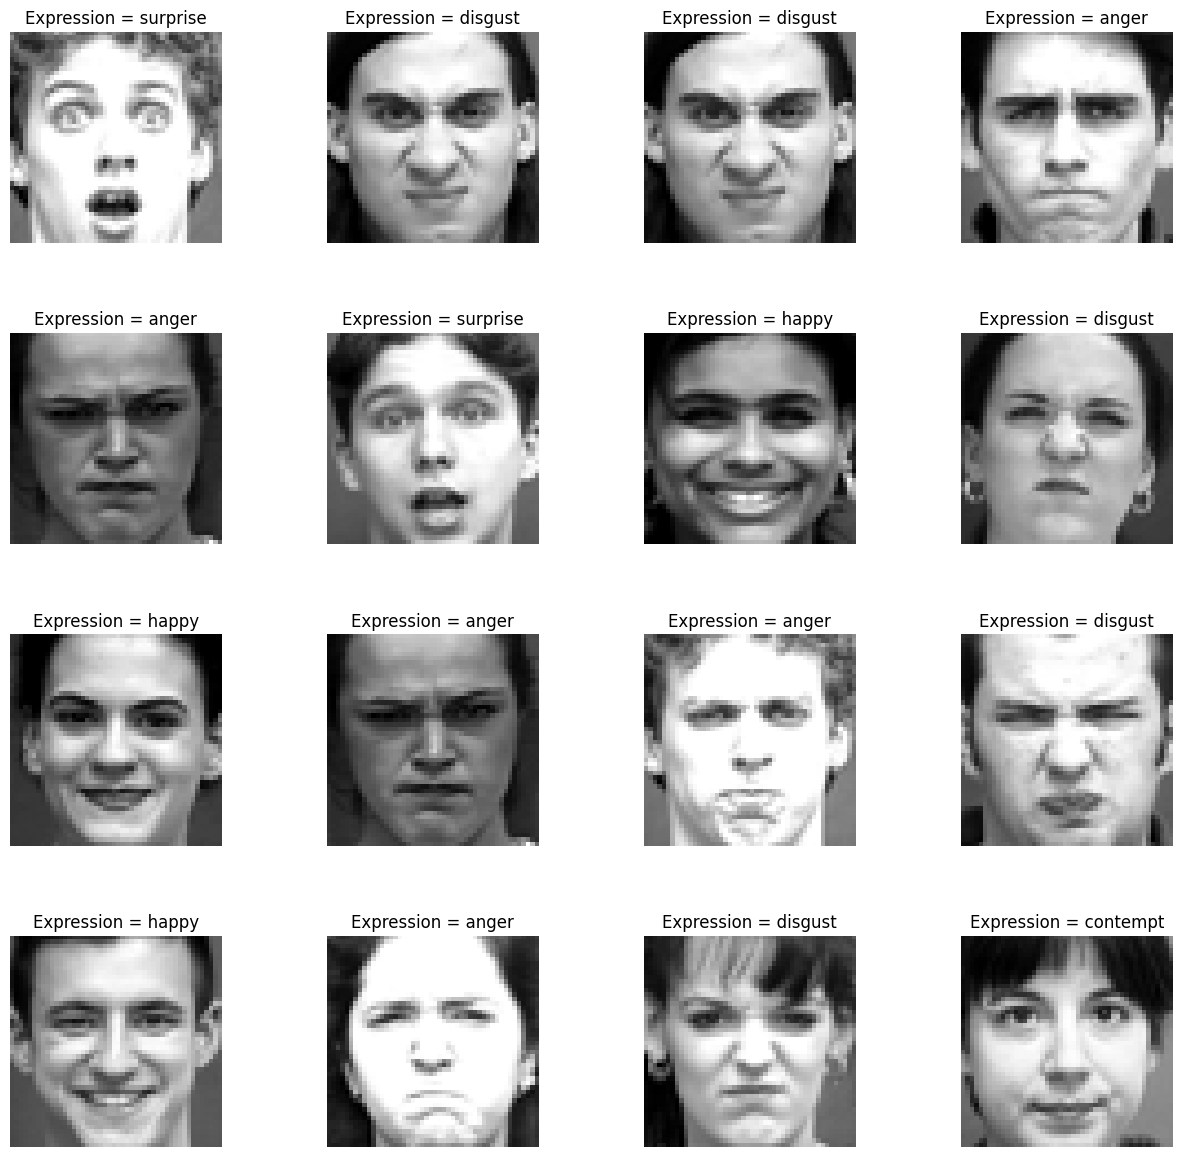

In [6]:
import matplotlib.pyplot as plt
L = 4
W = 4
fig, axes = plt.subplots(L, W, figsize = (15,15))
axes = axes.ravel()

for i in range(0, L*W):
    sample = random.choice(data)
    axes[i].set_title("Expression = "+str(CATEGORIES[sample[1]]))
    axes[i].imshow(sample[0], cmap='gray')
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

## KNN

## KNN Code H√†m

In [7]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

def extract_hog_features(image):
    """
    Tr√≠ch xu·∫•t ƒë·∫∑c tr∆∞ng HOG t·ª´ ·∫£nh grayscale.
    
    Parameters:
        image (np.ndarray): ·∫¢nh ƒë·∫ßu v√†o d·∫°ng grayscale.
        
    Returns:
        np.ndarray: Vector ƒë·∫∑c tr∆∞ng HOG.
    """
    features = hog(image,
                   orientations=9,
                   pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2),
                   block_norm='L2-Hys',
                   visualize=False,
                   transform_sqrt=True)
    return features

def extract_dct_features(image, keep_coeffs=8):
    """
    Tr√≠ch xu·∫•t ƒë·∫∑c tr∆∞ng DCT t·ª´ ·∫£nh.
    
    Quy tr√¨nh:
      - Chuy·ªÉn ·∫£nh sang float32 v√† chu·∫©n h√≥a gi√° tr·ªã pixel v·ªÅ [0, 1].
      - T√≠nh DCT c·ªßa ·∫£nh b·∫±ng h√†m cv2.dct.
      - L·∫•y block g√≥c tr√™n b√™n tr√°i c√≥ k√≠ch th∆∞·ªõc keep_coeffs x keep_coeffs.
      - L√†m ph·∫≥ng block th√†nh vector ƒë·∫∑c tr∆∞ng.
    
    Parameters:
        image (np.ndarray): ·∫¢nh ƒë·∫ßu v√†o d·∫°ng grayscale.
        keep_coeffs (int): S·ªë coefficient c·∫ßn gi·ªØ tr√™n m·ªói chi·ªÅu (m·∫∑c ƒë·ªãnh 8, t·ª©c 8x8 = 64 ƒë·∫∑c tr∆∞ng).
        
    Returns:
        np.ndarray: Vector ƒë·∫∑c tr∆∞ng DCT.
    """
    img_float = np.float32(image) / 255.0
    dct = cv2.dct(img_float)
    dct_block = dct[:keep_coeffs, :keep_coeffs]
    return dct_block.flatten()

def extract_combined_features(images):
    """
    V·ªõi m·ªói ·∫£nh, tr√≠ch xu·∫•t ƒë·∫∑c tr∆∞ng HOG v√† DCT sau ƒë√≥ n·ªëi (concatenate) ch√∫ng l·∫°i th√†nh vector ƒë·∫∑c tr∆∞ng chung.
    
    Parameters:
        images (np.ndarray): M·∫£ng c√°c ·∫£nh.
    
    Returns:
        np.ndarray: Ma tr·∫≠n ƒë·∫∑c tr∆∞ng v·ªõi k√≠ch th∆∞·ªõc (s·ªë m·∫´u, s·ªë chi·ªÅu HOG + 64).
    """
    hog_feats = [extract_hog_features(img) for img in tqdm(images, desc="Extracting HOG features")]
    dct_feats = [extract_dct_features(img, keep_coeffs=8) for img in tqdm(images, desc="Extracting DCT features")]
    hog_feats = np.array(hog_feats)
    dct_feats = np.array(dct_feats)
    combined = np.concatenate((hog_feats, dct_feats), axis=1)
    return combined

combined_features = extract_combined_features(images)
print("S·ªë chi·ªÅu ban ƒë·∫ßu c·ªßa vector ƒë·∫∑c tr∆∞ng k·∫øt h·ª£p:", combined_features.shape[1])

Extracting DCT features: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 981/981 [00:00<00:00, 18808.54it/s]


S·ªë chi·ªÅu ban ƒë·∫ßu c·ªßa vector ƒë·∫∑c tr∆∞ng k·∫øt h·ª£p: 1828


S·ªë th√†nh ph·∫ßn ƒë∆∞·ª£c ch·ªçn: 208
T·ª∑ l·ªá ph∆∞∆°ng sai gi·∫£i th√≠ch: 0.9000637563180738


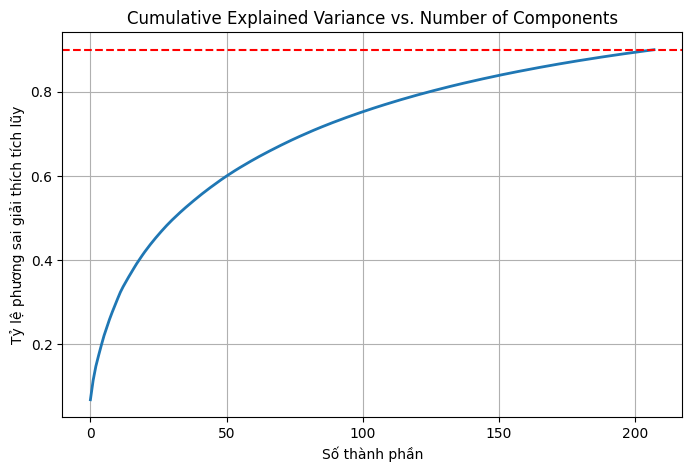

Best parameters cho KNN: {'n_neighbors': 1, 'weights': 'uniform'}
Best cross-validation accuracy: 0.9196553976808755
KNN Accuracy : 0.9847715736040609
Classification Report:
              precision    recall  f1-score   support

    surprise       1.00      1.00      1.00        42
        fear       1.00      1.00      1.00        21
     sadness       1.00      1.00      1.00        18
     disgust       1.00      0.92      0.96        37
    contempt       0.88      1.00      0.93        14
       happy       1.00      1.00      1.00        42
       anger       0.96      1.00      0.98        23

    accuracy                           0.98       197
   macro avg       0.98      0.99      0.98       197
weighted avg       0.99      0.98      0.98       197



In [8]:
def reduce_dimensionality(features, variance_threshold=0.95):
    """
    Chu·∫©n h√≥a v√† gi·∫£m chi·ªÅu vector ƒë·∫∑c tr∆∞ng b·∫±ng StandardScaler v√† PCA, 
    t·ª± ƒë·ªông gi·ªØ l·∫°i ƒë·ªß s·ªë th√†nh ph·∫ßn ƒë·ªÉ t·ªïng t·ª∑ l·ªá ph∆∞∆°ng sai gi·∫£i th√≠ch ƒë·∫°t ng∆∞·ª°ng nh·∫•t ƒë·ªãnh.
    
    Parameters:
        features (np.ndarray): Ma tr·∫≠n ƒë·∫∑c tr∆∞ng ban ƒë·∫ßu.
        variance_threshold (float): Ng∆∞·ª°ng t·ª∑ l·ªá ph∆∞∆°ng sai gi·∫£i th√≠ch (v√≠ d·ª• 0.95 nghƒ©a l√† 95%).
        
    Returns:
        features_pca (np.ndarray): Ma tr·∫≠n ƒë·∫∑c tr∆∞ng sau PCA.
        pca (PCA object): M√¥ h√¨nh PCA ƒë√£ fit.
    """
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    # S·ª≠ d·ª•ng PCA ƒë·ªÉ t·ª± ƒë·ªông ch·ªçn s·ªë th√†nh ph·∫ßn sao cho ƒë·∫°t ng∆∞·ª°ng explained variance
    pca = PCA(n_components=variance_threshold)
    features_pca = pca.fit_transform(scaled_features)
    
    print("S·ªë th√†nh ph·∫ßn ƒë∆∞·ª£c ch·ªçn:", pca.n_components_)
    print("T·ª∑ l·ªá ph∆∞∆°ng sai gi·∫£i th√≠ch:", np.sum(pca.explained_variance_ratio_))

    import matplotlib.pyplot as plt
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    plt.figure(figsize=(8, 5))
    plt.plot(cumulative_variance, linewidth=2)
    plt.xlabel("S·ªë th√†nh ph·∫ßn")
    plt.ylabel("T·ª∑ l·ªá ph∆∞∆°ng sai gi·∫£i th√≠ch t√≠ch l≈©y")
    plt.title("Cumulative Explained Variance vs. Number of Components")
    plt.grid(True)
    plt.axhline(y=variance_threshold, color='r', linestyle='--')
    plt.show()
    return features_pca, pca, scaler

features_pca, pca_model, scaler = reduce_dimensionality(combined_features, variance_threshold=0.9)
# -------------------------------
# Chia d·ªØ li·ªáu th√†nh t·∫≠p hu·∫•n luy·ªán v√† test
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(features_pca, labels, test_size=0.2, random_state=42)

# -------------------------------
# T·ªëi ∆∞u h√≥a si√™u tham s·ªë cho KNN b·∫±ng GridSearchCV
# -------------------------------
def grid_search_knn(X_train, y_train):
    """
    S·ª≠ d·ª•ng GridSearchCV ƒë·ªÉ t√¨m c√°c si√™u tham s·ªë t·ªëi ∆∞u cho KNN.
    
    Parameters:
        X_train (np.ndarray): Ma tr·∫≠n ƒë·∫∑c tr∆∞ng hu·∫•n luy·ªán.
        y_train (np.ndarray): Nh√£n hu·∫•n luy·ªán.
        
    Returns:
        best_knn (estimator): M√¥ h√¨nh KNN v·ªõi si√™u tham s·ªë t·ªëi ∆∞u.
        grid (GridSearchCV object): ƒê·ªëi t∆∞·ª£ng GridSearchCV ƒë√£ ƒë∆∞·ª£c fit.
    """
    param_grid = {
        'n_neighbors': [1, 3, 5, 7, 9],
        'weights': ['uniform', 'distance']
    }
    knn = KNeighborsClassifier()
    grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    print("Best parameters cho KNN:", grid.best_params_)
    print("Best cross-validation accuracy:", grid.best_score_)
    
    best_knn = grid.best_estimator_
    return best_knn, grid

start_time = time.time()
best_knn, grid = grid_search_knn(X_train, y_train)
knn_train_time = time.time() - start_time


y_pred_knn = best_knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
print("KNN Accuracy :", acc_knn)
print("Classification Report:")
print(classification_report(y_test, y_pred_knn, target_names=CATEGORIES))





S·ªë th√†nh ph·∫ßn ƒë∆∞·ª£c ch·ªçn: 208
T·ª∑ l·ªá ph∆∞∆°ng sai gi·∫£i th√≠ch: 0.9000637563180738


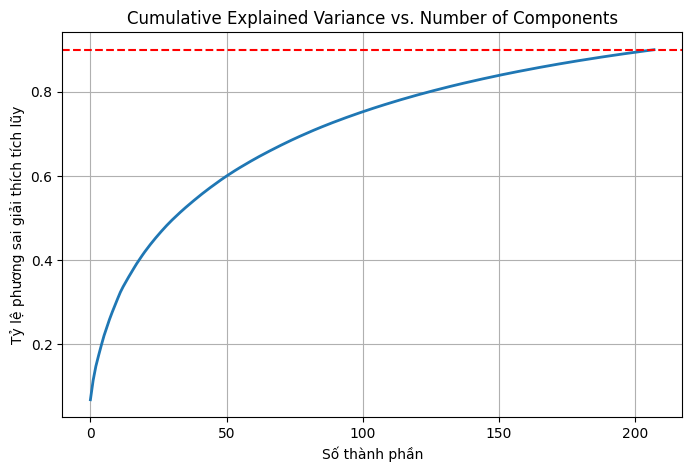

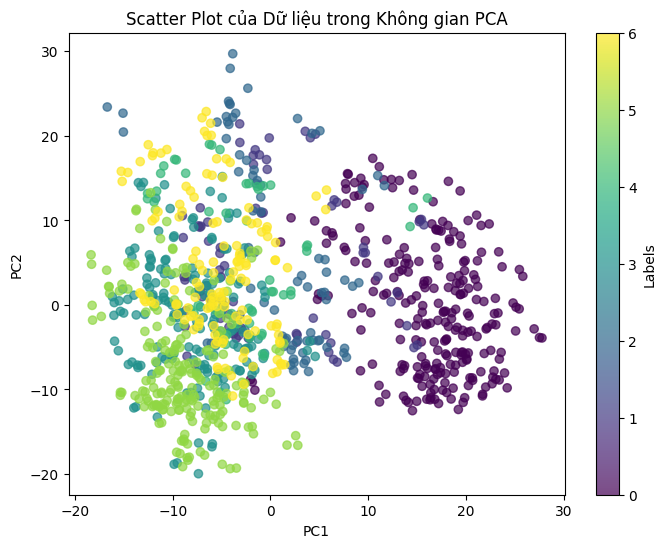

Best parameters cho KNN: {'n_neighbors': 1, 'weights': 'uniform'}
Best cross-validation accuracy: 0.9196553976808755
KNN Accuracy: 0.9847715736040609
Classification Report:
              precision    recall  f1-score   support

    surprise       1.00      1.00      1.00        42
        fear       1.00      1.00      1.00        21
     sadness       1.00      1.00      1.00        18
     disgust       1.00      0.92      0.96        37
    contempt       0.88      1.00      0.93        14
       happy       1.00      1.00      1.00        42
       anger       0.96      1.00      0.98        23

    accuracy                           0.98       197
   macro avg       0.98      0.99      0.98       197
weighted avg       0.99      0.98      0.98       197



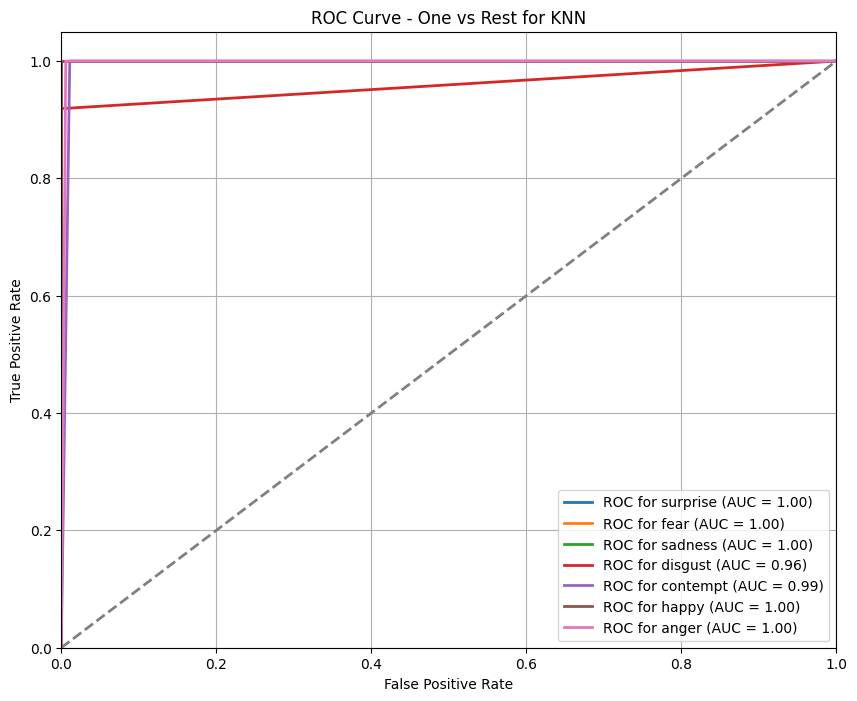

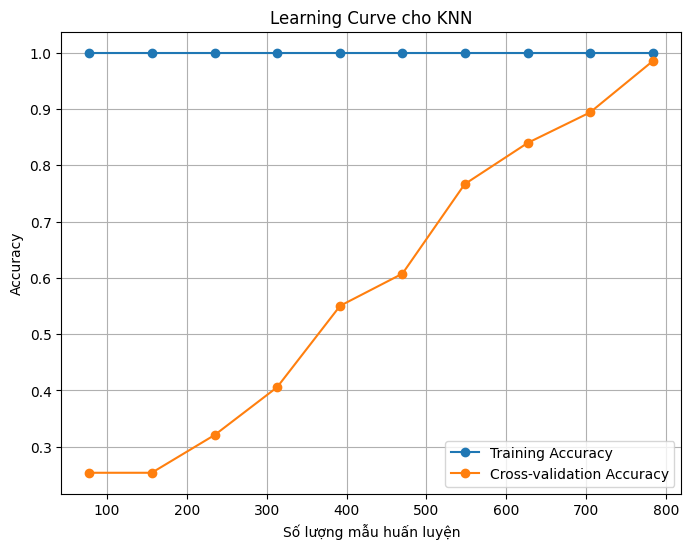

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import time

from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

#############################################
# 1. H√†m gi·∫£m chi·ªÅu v·ªõi PCA & Bi·ªÉu ƒë·ªì Cumulative Explained Variance
#############################################
def reduce_dimensionality(features, variance_threshold=0.95):
    """
    Chu·∫©n h√≥a v√† gi·∫£m chi·ªÅu vector ƒë·∫∑c tr∆∞ng b·∫±ng StandardScaler v√† PCA, 
    t·ª± ƒë·ªông gi·ªØ l·∫°i ƒë·ªß s·ªë th√†nh ph·∫ßn ƒë·ªÉ t·ªïng t·ª∑ l·ªá ph∆∞∆°ng sai gi·∫£i th√≠ch ƒë·∫°t ng∆∞·ª°ng nh·∫•t ƒë·ªãnh.

    Parameters:
        features (np.ndarray): Ma tr·∫≠n ƒë·∫∑c tr∆∞ng ban ƒë·∫ßu.
        variance_threshold (float): Ng∆∞·ª°ng t·ª∑ l·ªá ph∆∞∆°ng sai gi·∫£i th√≠ch (v√≠ d·ª• 0.95 nghƒ©a l√† 95%).

    Returns:
        features_pca (np.ndarray): Ma tr·∫≠n ƒë·∫∑c tr∆∞ng sau PCA.
        pca (PCA object): M√¥ h√¨nh PCA ƒë√£ fit.
        scaler (StandardScaler): B·ªô chu·∫©n h√≥a ƒë√£ fit.
    """
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # S·ª≠ d·ª•ng PCA ƒë·ªÉ t·ª± ƒë·ªông ch·ªçn s·ªë th√†nh ph·∫ßn sao cho ƒë·∫°t ng∆∞·ª°ng explained variance
    pca = PCA(n_components=variance_threshold)
    features_pca = pca.fit_transform(scaled_features)

    print("S·ªë th√†nh ph·∫ßn ƒë∆∞·ª£c ch·ªçn:", pca.n_components_)
    print("T·ª∑ l·ªá ph∆∞∆°ng sai gi·∫£i th√≠ch:", np.sum(pca.explained_variance_ratio_))

    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    plt.figure(figsize=(8, 5))
    plt.plot(cumulative_variance, linewidth=2)
    plt.xlabel("S·ªë th√†nh ph·∫ßn")
    plt.ylabel("T·ª∑ l·ªá ph∆∞∆°ng sai gi·∫£i th√≠ch t√≠ch l≈©y")
    plt.title("Cumulative Explained Variance vs. Number of Components")
    plt.grid(True)
    plt.axhline(y=variance_threshold, color='r', linestyle='--')
    plt.show()
    return features_pca, pca, scaler

# Gi·∫£m chi·ªÅu d·ªØ li·ªáu v·ªõi threshold 0.9 (90% ph∆∞∆°ng sai gi·∫£i th√≠ch)
features_pca, pca_model, scaler = reduce_dimensionality(combined_features, variance_threshold=0.9)

#############################################
# 2. Scatter Plot c·ªßa d·ªØ li·ªáu trong kh√¥ng gian PCA
#############################################
plt.figure(figsize=(8,6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Scatter Plot c·ªßa D·ªØ li·ªáu trong Kh√¥ng gian PCA")
plt.colorbar(label="Labels")
plt.show()

#############################################
# 3. T·ªëi ∆∞u h√≥a si√™u tham s·ªë cho KNN b·∫±ng GridSearchCV
#############################################
def grid_search_knn(X_train, y_train):
    """
    S·ª≠ d·ª•ng GridSearchCV ƒë·ªÉ t√¨m c√°c si√™u tham s·ªë t·ªëi ∆∞u cho KNN.
    
    Parameters:
        X_train (np.ndarray): Ma tr·∫≠n ƒë·∫∑c tr∆∞ng hu·∫•n luy·ªán.
        y_train (np.ndarray): Nh√£n hu·∫•n luy·ªán.
        
    Returns:
        best_knn (estimator): M√¥ h√¨nh KNN v·ªõi si√™u tham s·ªë t·ªëi ∆∞u.
        grid (GridSearchCV object): ƒê·ªëi t∆∞·ª£ng GridSearchCV ƒë√£ ƒë∆∞·ª£c fit.
    """
    param_grid = {
        'n_neighbors': [1, 3, 5, 7, 9],
        'weights': ['uniform', 'distance']
    }
    knn = KNeighborsClassifier()
    grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)

    print("Best parameters cho KNN:", grid.best_params_)
    print("Best cross-validation accuracy:", grid.best_score_)

    best_knn = grid.best_estimator_
    return best_knn, grid

# Chia d·ªØ li·ªáu th√†nh t·∫≠p hu·∫•n luy·ªán v√† test
X_train, X_test, y_train, y_test = train_test_split(features_pca, labels, test_size=0.2, random_state=42)

# T√¨m si√™u tham s·ªë t·ªëi ∆∞u cho KNN
best_knn, grid = grid_search_knn(X_train, y_train)

#############################################
# 4. ƒê√°nh gi√° m√¥ h√¨nh KNN tr√™n t·∫≠p test
#############################################
y_pred = best_knn.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("KNN Accuracy:", acc)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=CATEGORIES))


#############################################
# 6. ROC Curve theo One-vs-Rest cho KNN
#############################################
# ƒê·ªÉ v·∫Ω ROC Curve cho b√†i to√°n ƒëa l·ªõp, ta c·∫ßn chuy·ªÉn ƒë·ªïi nh√£n v·ªÅ d·∫°ng nh·ªã ph√¢n.
n_classes = len(CATEGORIES)
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

# S·ª≠ d·ª•ng predict_proba c·ªßa KNN ƒë·ªÉ l·∫•y x√°c su·∫•t d·ª± ƒëo√°n
y_score = best_knn.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10,8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC for {CATEGORIES[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - One vs Rest for KNN')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

#############################################
# 7. Learning Curve: ·∫¢nh h∆∞·ªüng c·ªßa s·ªë l∆∞·ª£ng m·∫´u hu·∫•n luy·ªán ƒë·∫øn Accuracy
#############################################
train_sizes, train_scores, cv_scores = learning_curve(best_knn, features_pca, labels, cv=5,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        scoring='accuracy', n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
cv_scores_mean = np.mean(cv_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_scores_mean, marker='o', linestyle='-', label="Training Accuracy")
plt.plot(train_sizes, cv_scores_mean, marker='o', linestyle='-', label="Cross-validation Accuracy")
plt.xlabel("S·ªë l∆∞·ª£ng m·∫´u hu·∫•n luy·ªán")
plt.ylabel("Accuracy")
plt.title("Learning Curve cho KNN")
plt.legend(loc="best")
plt.grid(True)
plt.show()


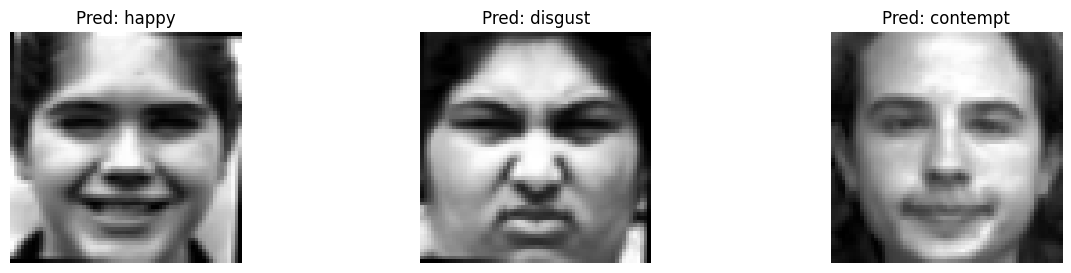

In [10]:
def predict_image(img_path, knn_model, scaler, pca):
    """
    H√†m n√†y nh·∫≠n ƒë∆∞·ªùng d·∫´n ƒë·∫øn ·∫£nh, th·ª±c hi·ªán ti·ªÅn x·ª≠ l√Ω v√† tr√≠ch xu·∫•t ƒë·∫∑c tr∆∞ng (HOG + DCT),
    sau ƒë√≥ chu·∫©n h√≥a v√† gi·∫£m chi·ªÅu b·∫±ng scaler v√† PCA ƒë√£ hu·∫•n luy·ªán.
    Cu·ªëi c√πng, m√¥ h√¨nh KNN ƒë∆∞·ª£c d√πng ƒë·ªÉ d·ª± ƒëo√°n nh√£n c·ªßa ·∫£nh.

    Parameters:
        img_path (str): ƒê∆∞·ªùng d·∫´n ƒë·∫øn ·∫£nh.
        knn_model (estimator): M√¥ h√¨nh KNN ƒë√£ ƒë∆∞·ª£c hu·∫•n luy·ªán.
        scaler (StandardScaler): ƒê·ªëi t∆∞·ª£ng scaler ƒë√£ fit tr√™n d·ªØ li·ªáu hu·∫•n luy·ªán.
        pca (PCA): M√¥ h√¨nh PCA ƒë√£ ƒë∆∞·ª£c fit tr√™n d·ªØ li·ªáu hu·∫•n luy·ªán.

    Returns:
        tuple: (predicted_label, processed_img)
    """
    processed_img = preprocess_image(img_path)  # H√†m preprocess_image ph·∫£i ƒë∆∞·ª£c ƒë·ªãnh nghƒ©a s·∫µn trong pipeline c·ªßa b·∫°n
    if processed_img is None:
        raise ValueError("Kh√¥ng ƒë·ªçc ƒë∆∞·ª£c ·∫£nh t·ª´ ƒë∆∞·ªùng d·∫´n: " + img_path)
    
    hog_feat = extract_hog_features(processed_img)
    dct_feat = extract_dct_features(processed_img, keep_coeffs=8)  # 8x8 = 64 ƒë·∫∑c tr∆∞ng
    combined = np.concatenate((hog_feat, dct_feat))
    
    # Chu·∫©n h√≥a vector ƒë·∫∑c tr∆∞ng theo scaler ƒë√£ h·ªçc (v·ªõi input l√† m·ªôt m·∫£ng 2 chi·ªÅu)
    combined_scaled = scaler.transform([combined])
    # Gi·∫£m chi·ªÅu vector ƒë·∫∑c tr∆∞ng s·ª≠ d·ª•ng PCA ƒë√£ h·ªçc
    combined_pca = pca.transform(combined_scaled)
    predicted = knn_model.predict(combined_pca)
    return predicted[0], processed_img

# Danh s√°ch ƒë∆∞·ªùng d·∫´n ·∫£nh c·∫ßn d·ª± ƒëo√°n v√≠ d·ª•:
test_image_paths = [
    '/kaggle/input/ck-dataset/happy/S011_006_00000011.png',
    '/kaggle/input/ck-dataset/disgust/S005_001_00000009.png',
    '/kaggle/input/ck-dataset/contempt/S151_002_00000029.png'
]

fig, axes = plt.subplots(1, len(test_image_paths), figsize=(15, 3))
for ax, img_path in zip(axes, test_image_paths):
    pred_label, img = predict_image(img_path, best_knn, scaler, pca_model)
    ax.imshow(img, cmap='gray')
    ax.set_title("Pred: " + CATEGORIES[pred_label])
    ax.axis('off')

plt.show()

## SVM

## SVM Code H√†m

S·ªë th√†nh ph·∫ßn ƒë∆∞·ª£c ch·ªçn: 292
T·ª∑ l·ªá ph∆∞∆°ng sai gi·∫£i th√≠ch: 0.9503447711801198


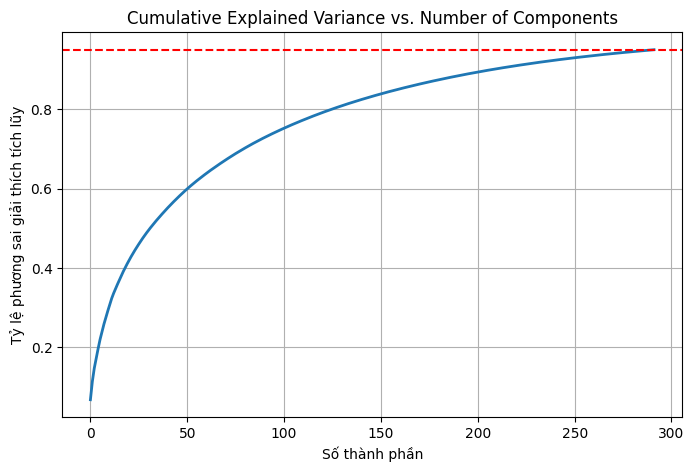

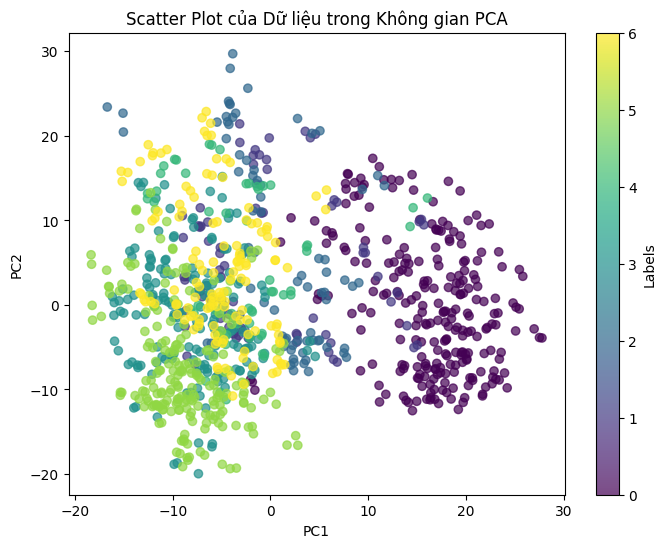

Best parameters: {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation accuracy: 0.9744977951984322

Epoch 1/5
Train Accuracy: 1.0
Test Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

    surprise       1.00      1.00      1.00        42
        fear       1.00      1.00      1.00        21
     sadness       1.00      1.00      1.00        18
     disgust       1.00      1.00      1.00        37
    contempt       1.00      1.00      1.00        14
       happy       1.00      1.00      1.00        42
       anger       1.00      1.00      1.00        23

    accuracy                           1.00       197
   macro avg       1.00      1.00      1.00       197
weighted avg       1.00      1.00      1.00       197

--------------------------------------------------
Best parameters: {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation accuracy: 0.9859464314878327

Epoch 2/5
Train Accuracy: 1.0
Test Accurac

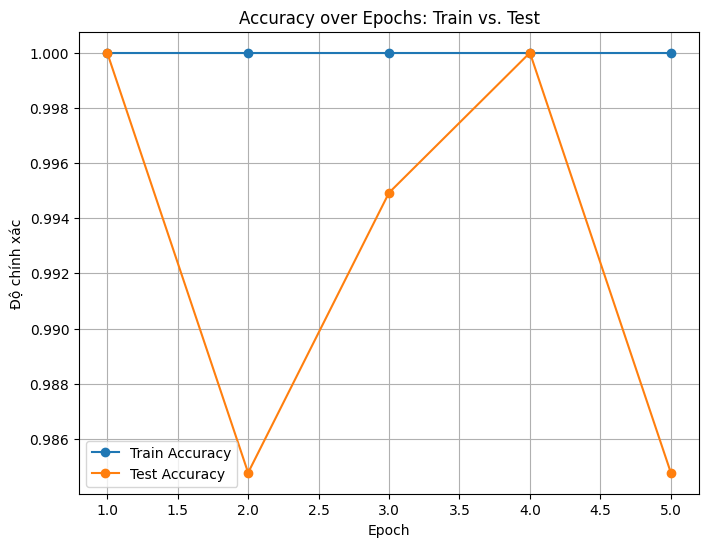

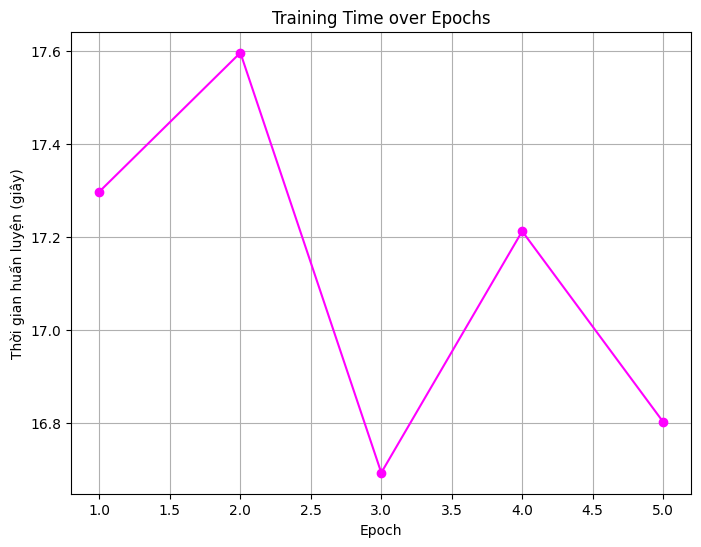

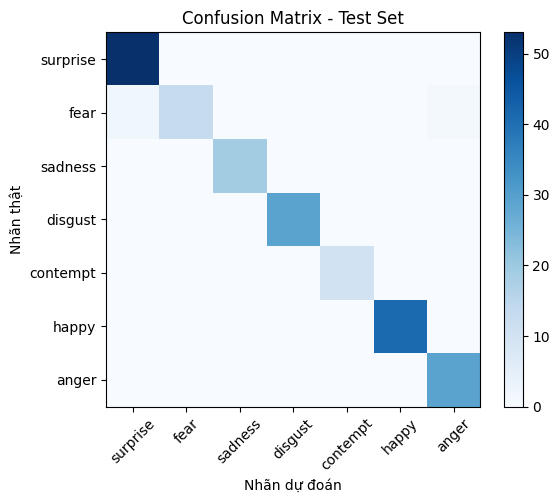

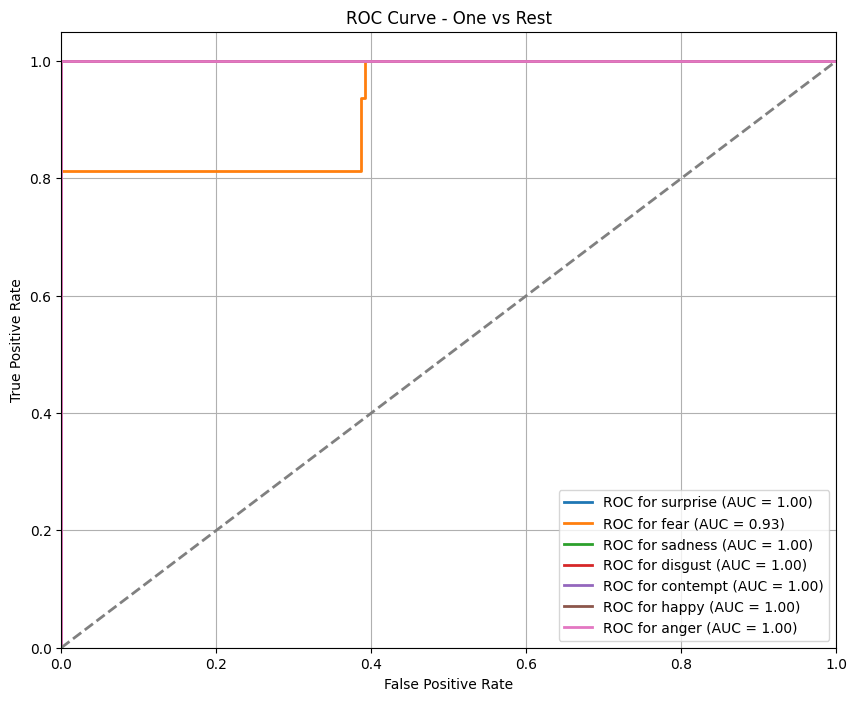

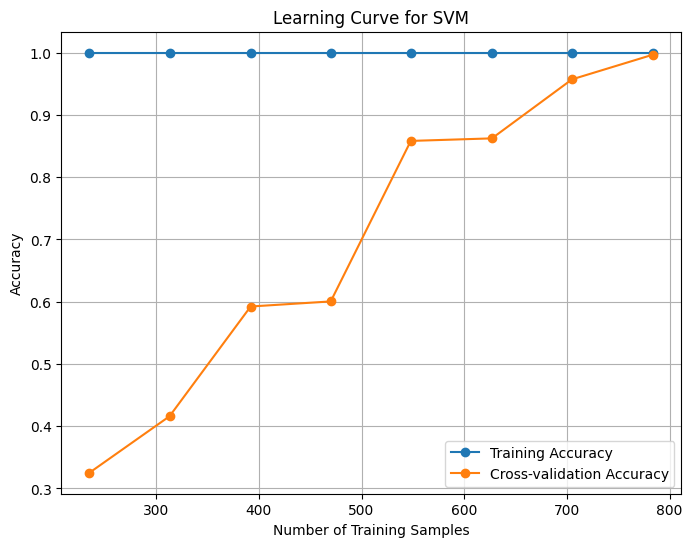

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import time

from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Gi·∫£ s·ª≠:
#   combined_features: ma tr·∫≠n ƒë·∫∑c tr∆∞ng ban ƒë·∫ßu (numpy.ndarray)
#   labels: vector nh√£n t∆∞∆°ng ·ª©ng (numpy.ndarray)
#   CATEGORIES: danh s√°ch t√™n c√°c l·ªõp (v√≠ d·ª•: ['Class1', 'Class2', 'Class3', ...])
# L∆∞u √Ω: CATEGORIES ph·∫£i kh·ªõp v·ªõi c√°c gi√° tr·ªã nh√£n (0,1,2,...)

#############################################
# 1. Gi·∫£m chi·ªÅu d·ªØ li·ªáu v·ªõi PCA & Bi·ªÉu ƒë·ªì Cumulative Explained Variance
#############################################
def reduce_dimensionality(features, variance_threshold=0.95):
    """
    Chu·∫©n h√≥a v√† gi·∫£m chi·ªÅu vector ƒë·∫∑c tr∆∞ng b·∫±ng StandardScaler v√† PCA.
    T·ª± ƒë·ªông gi·ªØ l·∫°i ƒë·ªß s·ªë th√†nh ph·∫ßn ƒë·ªÉ t·ªïng t·ª∑ l·ªá ph∆∞∆°ng sai gi·∫£i th√≠ch ƒë·∫°t ng∆∞·ª°ng.
    
    Parameters:
       features (np.ndarray): Ma tr·∫≠n ƒë·∫∑c tr∆∞ng ban ƒë·∫ßu.
       variance_threshold (float): Ng∆∞·ª°ng t·ª∑ l·ªá ph∆∞∆°ng sai gi·∫£i th√≠ch (v√≠ d·ª• 0.95).
       
    Returns:
       features_pca (np.ndarray): Ma tr·∫≠n ƒë·∫∑c tr∆∞ng sau PCA.
       pca (PCA object): M√¥ h√¨nh PCA ƒë√£ fit.
       scaler (StandardScaler): B·ªô chu·∫©n h√≥a ƒë√£ fit.
    """
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    pca = PCA(n_components=variance_threshold)
    features_pca = pca.fit_transform(scaled_features)
    
    print("S·ªë th√†nh ph·∫ßn ƒë∆∞·ª£c ch·ªçn:", pca.n_components_)
    print("T·ª∑ l·ªá ph∆∞∆°ng sai gi·∫£i th√≠ch:", np.sum(pca.explained_variance_ratio_))
    
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    plt.figure(figsize=(8, 5))
    plt.plot(cumulative_variance, linewidth=2)
    plt.xlabel("S·ªë th√†nh ph·∫ßn")
    plt.ylabel("T·ª∑ l·ªá ph∆∞∆°ng sai gi·∫£i th√≠ch t√≠ch l≈©y")
    plt.title("Cumulative Explained Variance vs. Number of Components")
    plt.grid(True)
    plt.axhline(y=variance_threshold, color='r', linestyle='--')
    plt.show()
    
    return features_pca, pca, scaler

# Gi·∫£m chi·ªÅu d·ªØ li·ªáu (·ªü ƒë√¢y gi·ªØ l·∫°i 95% ph∆∞∆°ng sai gi·∫£i th√≠ch)
features_pca, pca_model, scaler = reduce_dimensionality(combined_features, variance_threshold=0.95)

#############################################
# 2. Scatter Plot c·ªßa d·ªØ li·ªáu trong kh√¥ng gian PCA
#############################################
plt.figure(figsize=(8,6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Scatter Plot c·ªßa D·ªØ li·ªáu trong Kh√¥ng gian PCA")
plt.colorbar(label="Labels")
plt.show()

#############################################
# 3. Hu·∫•n luy·ªán SVM b·∫±ng GridSearchCV qua c√°c epoch
#############################################
def grid_search_svm(X_train, y_train):
    """
    T√¨m c√°c si√™u tham s·ªë t·ªëi ∆∞u cho SVM b·∫±ng GridSearchCV.
    
    Parameters:
       X_train (np.ndarray): Ma tr·∫≠n ƒë·∫∑c tr∆∞ng hu·∫•n luy·ªán.
       y_train (np.ndarray): Nh√£n hu·∫•n luy·ªán.
       
    Returns:
       best_svm (estimator): M√¥ h√¨nh SVM v·ªõi si√™u tham s·ªë t·ªëi ∆∞u.
       grid (GridSearchCV object): ƒê·ªëi t∆∞·ª£ng grid search ƒë√£ ƒë∆∞·ª£c fit.
    """
    # Ch√∫ √Ω: ƒê·ªÉ thu·∫≠n ti·ªán t√≠nh ROC sau n√†y, ta k√≠ch ho·∫°t probability=True.
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    }
    
    svm = SVC(random_state=42, probability=True)  # probability=True ƒë·ªÉ t√≠nh ROC
    grid = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    print("Best parameters:", grid.best_params_)
    print("Best cross-validation accuracy:", grid.best_score_)
    best_svm = grid.best_estimator_
    return best_svm, grid

# S·ªë epoch (·ªü ƒë√¢y s·ª≠ d·ª•ng 5 epoch v√≠ d·ª•)
epochs = 5

train_accuracies = []
test_accuracies = []
training_times = []

for epoch in range(epochs):
    start_time = time.time()
    # Thay ƒë·ªïi random_state theo epoch ƒë·ªÉ c√≥ ƒë∆∞·ª£c ph√¢n chia d·ªØ li·ªáu kh√°c nhau
    X_train, X_test, y_train, y_test = train_test_split(features_pca, labels, test_size=0.2, random_state=42 + epoch)
    
    best_svm, grid = grid_search_svm(X_train, y_train)
    
    # T√≠nh ƒë·ªô ch√≠nh x√°c tr√™n t·∫≠p hu·∫•n luy·ªán v√† t·∫≠p test
    train_acc = accuracy_score(y_train, best_svm.predict(X_train))
    test_acc = accuracy_score(y_test, best_svm.predict(X_test))
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    training_times.append(elapsed_time)
    
    print(f"\nEpoch {epoch+1}/{epochs}")
    print("Train Accuracy:", train_acc)
    print("Test Accuracy:", test_acc)
    print("Classification Report:")
    print(classification_report(y_test, best_svm.predict(X_test), target_names=CATEGORIES))
    print("-"*50)

#############################################
# 4. Bi·ªÉu ƒë·ªì Accuracy theo Epoch (Train vs. Test)
#############################################
plt.figure(figsize=(8,6))
plt.plot(np.arange(1, epochs+1), train_accuracies, marker='o', linestyle='-', label="Train Accuracy")
plt.plot(np.arange(1, epochs+1), test_accuracies, marker='o', linestyle='-', label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("ƒê·ªô ch√≠nh x√°c")
plt.title("Accuracy over Epochs: Train vs. Test")
plt.legend()
plt.grid(True)
plt.show()

#############################################
# 5. Bi·ªÉu ƒë·ªì Th·ªùi gian Hu·∫•n luy·ªán qua c√°c Epoch
#############################################
plt.figure(figsize=(8,6))
plt.plot(np.arange(1, epochs+1), training_times, marker='o', linestyle='-', color='magenta')
plt.xlabel("Epoch")
plt.ylabel("Th·ªùi gian hu·∫•n luy·ªán (gi√¢y)")
plt.title("Training Time over Epochs")
plt.grid(True)
plt.show()

#############################################
# 6. Confusion Matrix cho t·∫≠p Test (t·ª´ epoch cu·ªëi c√πng)
#############################################
cm = confusion_matrix(y_test, best_svm.predict(X_test))
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.colorbar()
tick_marks = np.arange(len(CATEGORIES))
plt.xticks(tick_marks, CATEGORIES, rotation=45)
plt.yticks(tick_marks, CATEGORIES)
plt.ylabel("Nh√£n th·∫≠t")
plt.xlabel("Nh√£n d·ª± ƒëo√°n")
plt.tight_layout()
plt.show()

#############################################
# 7. ROC Curve theo One-vs-Rest cho t·∫≠p Test
#############################################
# Chuy·ªÉn ƒë·ªïi nh√£n c·ªßa t·∫≠p test th√†nh d·∫°ng nh·ªã ph√¢n.
# Gi·∫£ s·ª≠ c√°c l·ªõp ƒë∆∞·ª£c ƒë√°nh s·ªë t·ª´ 0 ƒë·∫øn len(CATEGORIES)-1.
n_classes = len(CATEGORIES)
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

# S·ª≠ d·ª•ng decision_function c·ªßa SVC ƒë·ªÉ l·∫•y ƒëi·ªÉm (scores)
y_score = best_svm.decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10,8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC for {CATEGORIES[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - One vs Rest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

#############################################
# 8. Learning Curve: S·ª± ·∫£nh h∆∞·ªüng c·ªßa k√≠ch th∆∞·ªõc t·∫≠p hu·∫•n luy·ªán ƒë·∫øn Accuracy
#############################################
train_sizes, train_scores, cv_scores = learning_curve(best_svm, features_pca, labels, cv=5,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        scoring='accuracy', n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
cv_scores_mean = np.mean(cv_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_scores_mean, marker='o', linestyle='-', label="Training Accuracy")
plt.plot(train_sizes, cv_scores_mean, marker='o', linestyle='-', label="Cross-validation Accuracy")
plt.xlabel("Number of Training Samples")
plt.ylabel("Accuracy")
plt.title("Learning Curve for SVM")
plt.legend(loc="best")
plt.grid(True)
plt.show()


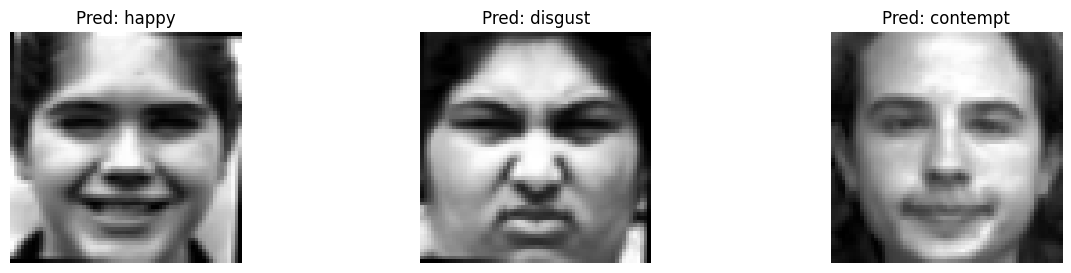

In [12]:
def predict_image(img_path, svm_model, scaler, pca):
    """
    H√†m n√†y nh·∫≠n ƒë∆∞·ªùng d·∫´n ƒë·∫øn ·∫£nh, th·ª±c hi·ªán ti·ªÅn x·ª≠ l√Ω v√† tr√≠ch xu·∫•t ƒë·∫∑c tr∆∞ng (HOG + DCT),
    sau ƒë√≥ chu·∫©n h√≥a v√† gi·∫£m chi·ªÅu b·∫±ng scaler v√† PCA ƒë√£ hu·∫•n luy·ªán.
    Cu·ªëi c√πng, m√¥ h√¨nh KNN ƒë∆∞·ª£c d√πng ƒë·ªÉ d·ª± ƒëo√°n nh√£n c·ªßa ·∫£nh.

    Parameters:
        img_path (str): ƒê∆∞·ªùng d·∫´n ƒë·∫øn ·∫£nh.
        knn_model (estimator): M√¥ h√¨nh KNN ƒë√£ ƒë∆∞·ª£c hu·∫•n luy·ªán.
        scaler (StandardScaler): ƒê·ªëi t∆∞·ª£ng scaler ƒë√£ fit tr√™n d·ªØ li·ªáu hu·∫•n luy·ªán.
        pca (PCA): M√¥ h√¨nh PCA ƒë√£ ƒë∆∞·ª£c fit tr√™n d·ªØ li·ªáu hu·∫•n luy·ªán.

    Returns:
        tuple: (predicted_label, processed_img)
    """
    processed_img = preprocess_image(img_path)  # H√†m preprocess_image ph·∫£i ƒë∆∞·ª£c ƒë·ªãnh nghƒ©a s·∫µn trong pipeline c·ªßa b·∫°n
    if processed_img is None:
        raise ValueError("Kh√¥ng ƒë·ªçc ƒë∆∞·ª£c ·∫£nh t·ª´ ƒë∆∞·ªùng d·∫´n: " + img_path)
    
    hog_feat = extract_hog_features(processed_img)
    dct_feat = extract_dct_features(processed_img, keep_coeffs=8)  # 8x8 = 64 ƒë·∫∑c tr∆∞ng
    combined = np.concatenate((hog_feat, dct_feat))
    
    # Chu·∫©n h√≥a vector ƒë·∫∑c tr∆∞ng theo scaler ƒë√£ h·ªçc (v·ªõi input l√† m·ªôt m·∫£ng 2 chi·ªÅu)
    combined_scaled = scaler.transform([combined])
    # Gi·∫£m chi·ªÅu vector ƒë·∫∑c tr∆∞ng s·ª≠ d·ª•ng PCA ƒë√£ h·ªçc
    combined_pca = pca.transform(combined_scaled)
    predicted = svm_model.predict(combined_pca)
    return predicted[0], processed_img

test_image_paths = [
    '/kaggle/input/ck-dataset/happy/S011_006_00000011.png',
    '/kaggle/input/ck-dataset/disgust/S005_001_00000009.png',
    '/kaggle/input/ck-dataset/contempt/S151_002_00000029.png'
]

fig, axes = plt.subplots(1, len(test_image_paths), figsize=(15, 3))
for ax, img_path in zip(axes, test_image_paths):
    pred_label, img = predict_image(img_path, best_svm, scaler, pca_model)
    ax.imshow(img, cmap='gray')
    ax.set_title("Pred: " + CATEGORIES[pred_label])
    ax.axis('off')

plt.show()

## SVM Code Tay

S·ªë th√†nh ph·∫ßn ƒë∆∞·ª£c ch·ªçn: 208
T·ª∑ l·ªá ph∆∞∆°ng sai gi·∫£i th√≠ch: 0.9000637563180738


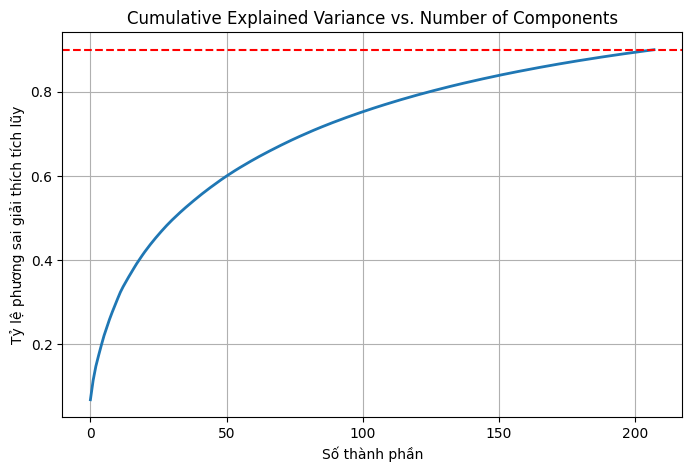

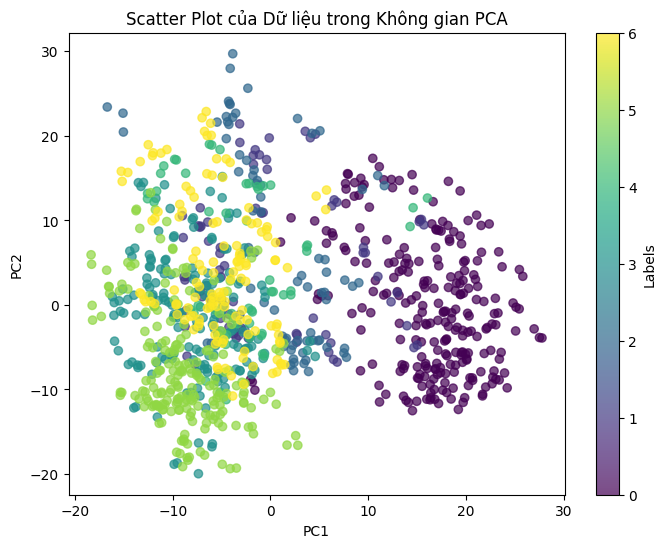

Epoch 10/100, Training Accuracy: 1.0000
Epoch 10/100, Validation Accuracy: 0.9848
Epoch 20/100, Training Accuracy: 0.9987
Epoch 20/100, Validation Accuracy: 0.9898
Epoch 30/100, Training Accuracy: 1.0000
Epoch 30/100, Validation Accuracy: 0.9898
Epoch 40/100, Training Accuracy: 1.0000
Epoch 40/100, Validation Accuracy: 0.9949
Epoch 50/100, Training Accuracy: 1.0000
Epoch 50/100, Validation Accuracy: 0.9949
Epoch 60/100, Training Accuracy: 1.0000
Epoch 60/100, Validation Accuracy: 0.9949
Epoch 70/100, Training Accuracy: 1.0000
Epoch 70/100, Validation Accuracy: 0.9949
Epoch 80/100, Training Accuracy: 1.0000
Epoch 80/100, Validation Accuracy: 0.9949
Epoch 90/100, Training Accuracy: 1.0000
Epoch 90/100, Validation Accuracy: 0.9898
Epoch 100/100, Training Accuracy: 1.0000
Epoch 100/100, Validation Accuracy: 0.9898
Manual SVM Accuracy: 0.9898477157360406
              precision    recall  f1-score   support

    surprise       1.00      1.00      1.00        42
        fear       0.95      

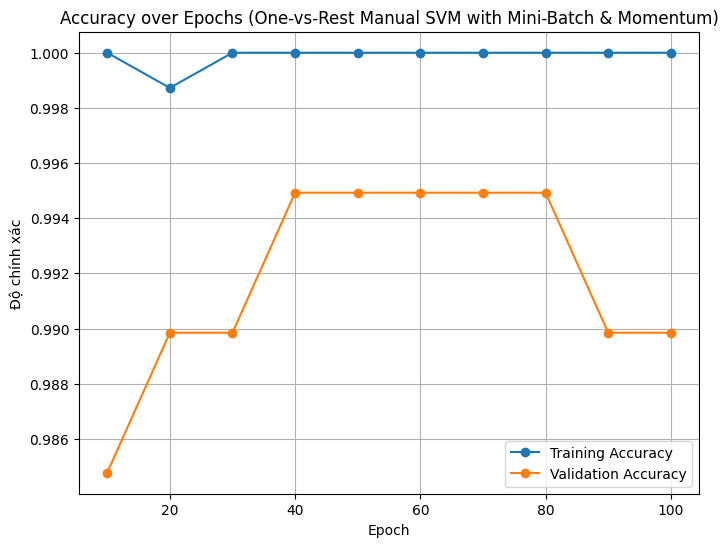

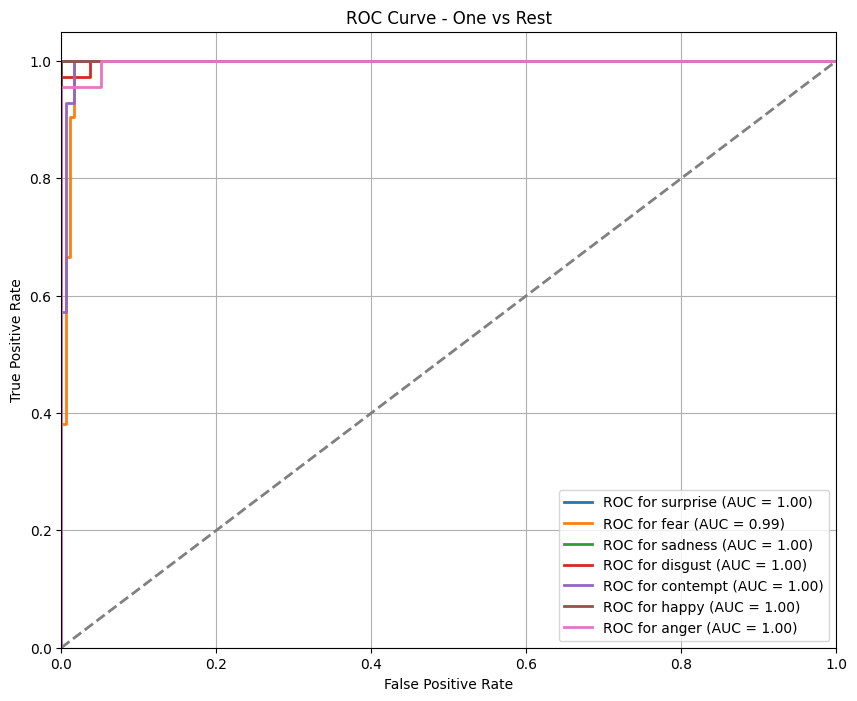

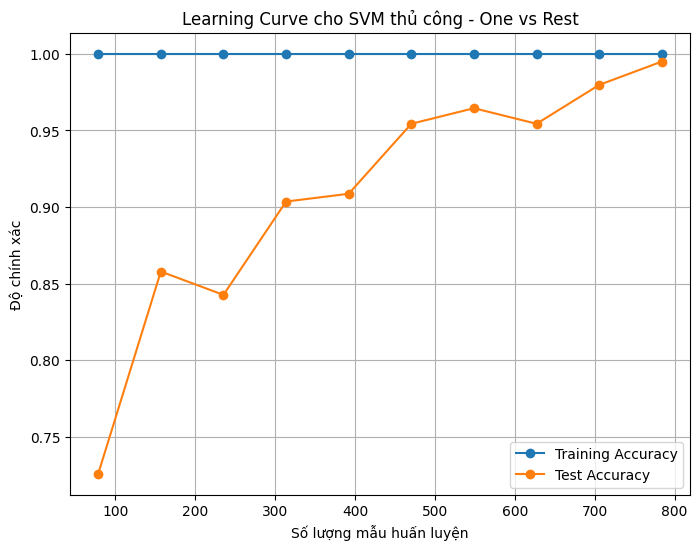

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Gi·∫£ s·ª≠:
#   combined_features: ma tr·∫≠n ƒë·∫∑c tr∆∞ng ban ƒë·∫ßu (numpy.ndarray)
#   labels: vector nh√£n t∆∞∆°ng ·ª©ng (numpy.ndarray)
#   CATEGORIES: danh s√°ch t√™n c√°c l·ªõp (v√≠ d·ª•: ['Class1', 'Class2', 'Class3'])

### 1. H√†m gi·∫£m chi·ªÅu v·ªõi PCA v√† tr·ª±c quan h√≥a Cumulative Explained Variance
def reduce_dimensionality(features, variance_threshold=0.95):
    """
    H√†m n√†y chu·∫©n h√≥a d·ªØ li·ªáu, th·ª±c hi·ªán PCA v√† v·∫Ω bi·ªÉu ƒë·ªì t·ª∑ l·ªá ph∆∞∆°ng sai t√≠ch l≈©y.
    """
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    pca = PCA(n_components=variance_threshold)
    features_pca = pca.fit_transform(scaled_features)
    
    print("S·ªë th√†nh ph·∫ßn ƒë∆∞·ª£c ch·ªçn:", pca.n_components_)
    print("T·ª∑ l·ªá ph∆∞∆°ng sai gi·∫£i th√≠ch:", np.sum(pca.explained_variance_ratio_))
    
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    plt.figure(figsize=(8, 5))
    plt.plot(cumulative_variance, linewidth=2)
    plt.xlabel("S·ªë th√†nh ph·∫ßn")
    plt.ylabel("T·ª∑ l·ªá ph∆∞∆°ng sai gi·∫£i th√≠ch t√≠ch l≈©y")
    plt.title("Cumulative Explained Variance vs. Number of Components")
    plt.grid(True)
    plt.axhline(y=variance_threshold, color='r', linestyle='--')
    plt.show()
    
    return features_pca, pca, scaler

# Gi·∫£m chi·ªÅu d·ªØ li·ªáu (ƒë·∫∑t threshold=0.9 ƒë·ªÉ gi·ªØ 90% ph∆∞∆°ng sai gi·∫£i th√≠ch)
features_pca, pca_model, scaler = reduce_dimensionality(combined_features, variance_threshold=0.9)

### 2. Bi·ªÉu ƒë·ªì Scatter c·ªßa d·ªØ li·ªáu trong kh√¥ng gian PCA (to√†n b·ªô d·ªØ li·ªáu)
plt.figure(figsize=(8,6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Scatter Plot c·ªßa D·ªØ li·ªáu trong Kh√¥ng gian PCA")
plt.colorbar(label="Labels")
plt.show()

### 3. ƒê·ªãnh nghƒ©a m√¥ h√¨nh One-vs-Rest SVM "th·ªß c√¥ng" s·ª≠ d·ª•ng Mini-Batch Gradient Descent k·∫øt h·ª£p v·ªõi Momentum
class OneVsRestSVM:
    """
    C√†i ƒë·∫∑t SVM theo chi·∫øn l∆∞·ª£c One-vs-Rest s·ª≠ d·ª•ng mini-batch gradient descent k·∫øt h·ª£p v·ªõi momentum cho h√†m m·∫•t m√°t hinge.

    H√†m m·∫•t m√°t (loss) ƒë·ªëi v·ªõi m·ªôt b·ªô ph√¢n l·ªõp nh·ªã ph√¢n ƒë∆∞·ª£c ƒë·ªãnh nghƒ©a l√†:
    
        L(w, b) = (lambda_reg/2) * ||w||^2 + sum_{i=1}^{N} max(0, 1 - y_i*(w^T x_i + b))
    
    Trong ƒë√≥:
      - lambda_reg: H·ªá s·ªë regularization (ƒëi·ªÅu ch·ªânh ƒë·ªô ph·∫°t c·ªßa norm w).
      - ||w||^2: B√¨nh ph∆∞∆°ng chu·∫©n L2 c·ªßa vector tr·ªçng s·ªë.
      - max(0, 1 - y_i*(w^T x_i + b)) l√† h√†m hinge loss v·ªõi y_i ‚àà {+1, -1}.
    
    C√¥ng th·ª©c gradient c·ªßa h√†m m·∫•t m√°t ƒë·ªëi v·ªõi m·ªói m·∫´u:
      N·∫øu margin = 1 - y_i * (w^T x_i + b) > 0, th√¨:
          grad_w_i = - y_i * x_i   v√†  grad_b_i = - y_i
      N·∫øu margin <= 0, th√¨:
          grad_w_i = 0 v√† grad_b_i = 0
          
    Sau ƒë√≥, t·ªïng gradient tr√™n mini-batch v·ªõi regularization:
          grad_w = lambda_reg * w - sum_{i where margin > 0} (y_i * x_i)
          grad_b = - sum_{i where margin > 0} (y_i)
    
    Mini-Batch Gradient Descent:
      - Chia t·∫≠p hu·∫•n luy·ªán th√†nh c√°c mini-batch c√≥ k√≠ch th∆∞·ªõc batch_size.
      - T√≠nh gradient tr√™n m·ªói mini-batch v√† c·∫≠p nh·∫≠t tr·ªçng s·ªë.
    
    Momentum:
      - S·ª≠ d·ª•ng v·∫≠n t·ªëc (velocity) ƒë·ªÉ l∆∞u tr·ªØ s·ª± thay ƒë·ªïi c·ªßa tr·ªçng s·ªë, c·∫≠p nh·∫≠t theo c√¥ng th·ª©c:
            v = momentum * v - learning_rate * gradient
        Sau ƒë√≥, c·∫≠p nh·∫≠t tr·ªçng s·ªë:
            w = w + v
    """
    def __init__(self, learning_rate=0.001, n_epochs=100, lambda_reg=0.01, batch_size=32, momentum=0.9):
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.lambda_reg = lambda_reg
        self.batch_size = batch_size
        self.momentum = momentum
        self.classes_ = None
        self.W = {}  # L∆∞u tr·ªçng s·ªë (w) v√† bias (b) cho m·ªói l·ªõp.
        self.V = {}  # L∆∞u v·∫≠n t·ªëc (velocity) cho c·∫≠p nh·∫≠t momentum c·ªßa t·ª´ng l·ªõp.

    def fit(self, X, y, X_val=None, y_val=None, track_history=False, history_step=10):
        """
        Hu·∫•n luy·ªán m√¥ h√¨nh s·ª≠ d·ª•ng mini-batch gradient descent k·∫øt h·ª£p v·ªõi momentum.

        Parameters:
            X (np.ndarray): D·ªØ li·ªáu hu·∫•n luy·ªán.
            y (np.ndarray): Nh√£n hu·∫•n luy·ªán.
            X_val (np.ndarray): D·ªØ li·ªáu ki·ªÉm tra (tu·ª≥ ch·ªçn) ƒë·ªÉ theo d√µi accuracy qua c√°c epoch.
            y_val (np.ndarray): Nh√£n c·ªßa d·ªØ li·ªáu ki·ªÉm tra.
            track_history (bool): N·∫øu True, theo d√µi accuracy qua epoch.
            history_step (int): M·ªói bao nhi√™u epoch t√≠nh accuracy.

        Returns:
            history: dict ch·ª©a 'epoch', 'train_acc' v√† (n·∫øu c√≥) 'val_acc'
        """
        self.classes_ = np.unique(y)
        n_samples, n_features = X.shape
        
        # Kh·ªüi t·∫°o tr·ªçng s·ªë, bias v√† velocity cho t·ª´ng l·ªõp.
        for c in self.classes_:
            self.W[c] = (np.zeros(n_features), 0)     # w v√† b kh·ªüi t·∫°o b·∫±ng 0
            self.V[c] = (np.zeros(n_features), 0)       # velocity cho w v√† b kh·ªüi t·∫°o b·∫±ng 0
        
        history = {'epoch': [], 'train_acc': []}
        if X_val is not None and y_val is not None:
            history['val_acc'] = []
        
        # Hu·∫•n luy·ªán theo epoch:
        for epoch in range(1, self.n_epochs + 1):
            # Tr·ªôn ng·∫´u nhi√™n d·ªØ li·ªáu hu·∫•n luy·ªán ƒë·ªÉ t·∫°o c√°c mini-batch ng·∫´u nhi√™n.
            permutation = np.random.permutation(n_samples)
            X_shuffled = X[permutation]
            y_shuffled = y[permutation]
            
            # Duy·ªát qua t·ª´ng mini-batch
            for i in range(0, n_samples, self.batch_size):
                X_batch = X_shuffled[i:i + self.batch_size]
                y_batch = y_shuffled[i:i + self.batch_size]
                
                # C·∫≠p nh·∫≠t cho t·ª´ng l·ªõp
                for c in self.classes_:
                    # Chuy·ªÉn ƒë·ªïi nh√£n trong mini-batch v·ªÅ d·∫°ng nh·ªã ph√¢n: +1 n·∫øu thu·ªôc l·ªõp c, -1 n·∫øu kh√¥ng.
                    y_binary = np.where(y_batch == c, 1, -1)
                    
                    # L·∫•y tr·ªçng s·ªë v√† bias hi·ªán t·∫°i c·ªßa l·ªõp c.
                    w, b = self.W[c]
                    
                    # T√≠nh margin cho c√°c m·∫´u trong mini-batch:
                    # margin = 1 - y_i * (w^T x_i + b)
                    margins = 1 - y_binary * (np.dot(X_batch, w) + b)
                    
                    # X√°c ƒë·ªãnh c√°c m·∫´u vi ph·∫°m margin (margin > 0)
                    idx = margins > 0
                    
                    # T√≠nh gradient d·ª±a tr√™n c√°c c√¥ng th·ª©c:
                    # grad_w = lambda_reg * w - sum_{i in mini-batch and margin > 0} (y_i * x_i)
                    # grad_b = - sum_{i in mini-batch and margin > 0} (y_i)
                    if np.sum(idx) > 0:
                        grad_w = self.lambda_reg * w - np.dot(X_batch[idx].T, y_binary[idx])
                        grad_b = -np.sum(y_binary[idx])
                    else:
                        grad_w = self.lambda_reg * w
                        grad_b = 0
                    
                    # L·∫•y velocity hi·ªán t·∫°i cho l·ªõp c
                    v_w, v_b = self.V[c]
                    
                    # C·∫≠p nh·∫≠t velocity theo c√¥ng th·ª©c momentum:
                    # v = momentum * v - learning_rate * gradient
                    v_w = self.momentum * v_w - self.learning_rate * grad_w
                    v_b = self.momentum * v_b - self.learning_rate * grad_b
                    
                    # C·∫≠p nh·∫≠t tr·ªçng s·ªë v√† bias b·∫±ng c√°ch c·ªông velocity:
                    # w = w + v, b = b + v_b
                    w = w + v_w
                    b = b + v_b
                    
                    # L∆∞u l·∫°i tr·ªçng s·ªë, bias v√† velocity ƒë√£ c·∫≠p nh·∫≠t cho l·ªõp c.
                    self.W[c] = (w, b)
                    self.V[c] = (v_w, v_b)
            
            # Theo d√µi v√† l∆∞u l·∫°i accuracy sau m·ªói history_step epoch.
            if track_history and epoch % history_step == 0:
                y_pred_train = self.predict(X)
                train_acc = accuracy_score(y, y_pred_train)
                history['epoch'].append(epoch)
                history['train_acc'].append(train_acc)
                print(f"Epoch {epoch}/{self.n_epochs}, Training Accuracy: {train_acc:.4f}")
                if X_val is not None and y_val is not None:
                    y_pred_val = self.predict(X_val)
                    val_acc = accuracy_score(y_val, y_pred_val)
                    history['val_acc'].append(val_acc)
                    print(f"Epoch {epoch}/{self.n_epochs}, Validation Accuracy: {val_acc:.4f}")
                    
        return history

    def decision_function(self, X):
        """
        T√≠nh ƒëi·ªÉm (score) cho m·ªói l·ªõp cho t·∫≠p d·ªØ li·ªáu X.
        D√πng ƒë·ªÉ x√°c ƒë·ªãnh nh√£n d·ª± ƒëo√°n v√† tr·ª±c quan ROC Curve.
        """
        n_samples = X.shape[0]
        scores = np.zeros((n_samples, len(self.classes_)))  # ma tr·∫≠n score (n_samples x s·ªë l·ªõp)
        for i, c in enumerate(self.classes_):
            w, b = self.W[c]
            scores[:, i] = np.dot(X, w) + b
        return scores

    def predict(self, X):
        """
        D·ª± ƒëo√°n nh√£n cho c√°c m·∫´u trong X b·∫±ng c√°ch ch·ªçn l·ªõp c√≥ ƒëi·ªÉm s·ªë cao nh·∫•t.
        """
        scores = self.decision_function(X)
        predictions = np.argmax(scores, axis=1)
        return predictions

### 4. Chia d·ªØ li·ªáu v√† hu·∫•n luy·ªán m√¥ h√¨nh v·ªõi tracking qua epoch (s·ª≠ d·ª•ng n_epochs t·ª´ 5 ƒë·∫øn 100)
X_train, X_test, y_train, y_test = train_test_split(features_pca, labels, test_size=0.2, random_state=42)

# S·ª≠ d·ª•ng 100 epoch (c√≥ th·ªÉ ƒëi·ªÅu ch·ªânh trong kho·∫£ng t·ª´ 5 ƒë·∫øn 100)
n_epochs = 100  
manual_svm = OneVsRestSVM(learning_rate=0.0005, n_epochs=n_epochs, lambda_reg=0.01, batch_size=32, momentum=0.9)
history = manual_svm.fit(X_train, y_train, X_val=X_test, y_val=y_test, track_history=True, history_step=10)

y_pred_manual = manual_svm.predict(X_test)
acc_manual = accuracy_score(y_test, y_pred_manual)
print("Manual SVM Accuracy:", acc_manual)
print(classification_report(y_test, y_pred_manual, target_names=CATEGORIES))

### 5. V·∫Ω ƒë∆∞·ªùng ch·∫°y Accuracy theo Epoch
plt.figure(figsize=(8,6))
plt.plot(history['epoch'], history['train_acc'], marker='o', linestyle='-', label="Training Accuracy")
if 'val_acc' in history:
    plt.plot(history['epoch'], history['val_acc'], marker='o', linestyle='-', label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("ƒê·ªô ch√≠nh x√°c")
plt.title("Accuracy over Epochs (One-vs-Rest Manual SVM with Mini-Batch & Momentum)")
plt.legend()
plt.grid(True)
plt.show()


### 7. ROC Curve theo One-vs-Rest
n_classes = len(CATEGORIES)
y_test_bin = label_binarize(y_test, classes=manual_svm.classes_)
y_score = manual_svm.decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10,8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC for {CATEGORIES[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - One vs Rest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### 8. Learning Curve: ·∫¢nh h∆∞·ªüng c·ªßa k√≠ch th∆∞·ªõc t·∫≠p hu·∫•n luy·ªán ƒë·∫øn Accuracy
fractions = np.linspace(0.1, 1.0, 10)
train_accs = []
test_accs = []

for frac in fractions:
    idx = np.random.choice(len(X_train), int(frac * len(X_train)), replace=False)
    X_train_subset = X_train[idx]
    y_train_subset = y_train[idx]
    
    temp_svm = OneVsRestSVM(learning_rate=0.0005, n_epochs=n_epochs, lambda_reg=0.01, batch_size=32, momentum=0.9)
    temp_svm.fit(X_train_subset, y_train_subset)
    
    train_acc = accuracy_score(y_train_subset, temp_svm.predict(X_train_subset))
    test_acc = accuracy_score(y_test, temp_svm.predict(X_test))
    train_accs.append(train_acc)
    test_accs.append(test_acc)

plt.figure(figsize=(8,6))
plt.plot(fractions * len(X_train), train_accs, marker='o', linestyle='-', label="Training Accuracy")
plt.plot(fractions * len(X_train), test_accs, marker='o', linestyle='-', label="Test Accuracy")
plt.xlabel("S·ªë l∆∞·ª£ng m·∫´u hu·∫•n luy·ªán")
plt.ylabel("ƒê·ªô ch√≠nh x√°c")
plt.title("Learning Curve cho SVM th·ªß c√¥ng - One vs Rest")
plt.legend(loc="best")
plt.grid(True)
plt.show()


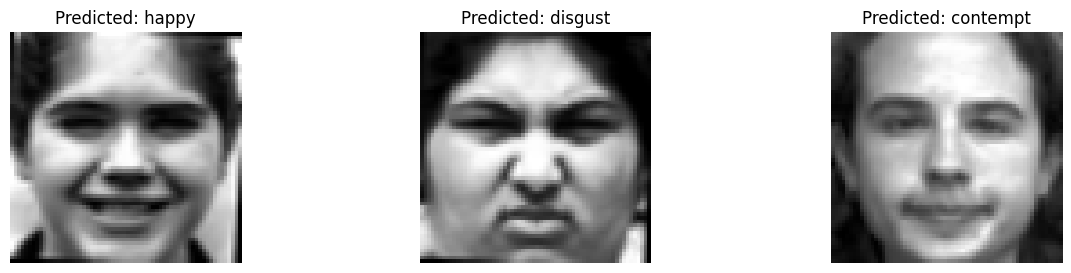

In [14]:

def predict_image(img_path, svm_model, scaler, pca):
    """
    D·ª± ƒëo√°n nh√£n cho ·∫£nh m·ªõi:
      - Ti·ªÅn x·ª≠ l√Ω ·∫£nh.
      - Tr√≠ch xu·∫•t ƒë·∫∑c tr∆∞ng HOG v√† DCT, sau ƒë√≥ k·∫øt h·ª£p ch√∫ng.
      - Chu·∫©n h√≥a v√† gi·∫£m chi·ªÅu b·∫±ng scaler v√† pca ƒë√£ h·ªçc.
      - D·ª± ƒëo√°n nh√£n b·∫±ng m√¥ h√¨nh SVM tay.
      
    Parameters:
        img_path (str): ƒê∆∞·ªùng d·∫´n ·∫£nh.
        svm_model (OneVsRestSVM): M√¥ h√¨nh SVM tay ƒë√£ hu·∫•n luy·ªán.
        scaler (StandardScaler): ƒê·ªëi t∆∞·ª£ng scaler ƒë√£ fit.
        pca (PCA): M√¥ h√¨nh PCA ƒë√£ fit.
        
    Returns:
        tuple: (predicted_label, processed_img)
    """
    proc_img = preprocess_image(img_path)
    if proc_img is None:
        raise ValueError("Kh√¥ng ƒë·ªçc ƒë∆∞·ª£c ·∫£nh t·ª´: " + img_path)
    
    hog_feat = extract_hog_features(proc_img)
    dct_feat = extract_dct_features(proc_img, keep_coeffs=8)
    combined = np.concatenate((hog_feat, dct_feat))
    
    combined_scaled = scaler.transform([combined])
    combined_pca = pca.transform(combined_scaled)
    
    pred = svm_model.predict(combined_pca)
    return pred[0], proc_img

# Danh s√°ch ƒë∆∞·ªùng d·∫´n ·∫£nh m·ªõi ƒë·ªÉ d·ª± ƒëo√°n
test_image_paths = [
    '/kaggle/input/ck-dataset/happy/S011_006_00000011.png',
    '/kaggle/input/ck-dataset/disgust/S005_001_00000009.png',
    '/kaggle/input/ck-dataset/contempt/S151_002_00000029.png'
]

fig, axes = plt.subplots(1, len(test_image_paths), figsize=(15, 3))
for ax, path in zip(axes, test_image_paths):
    pred_label, img = predict_image(path, manual_svm, scaler, pca_model)
    ax.imshow(img, cmap='gray')
    ax.set_title("Predicted: " + CATEGORIES[pred_label])
    ax.axis('off')
plt.show()


In [15]:
----

SyntaxError: invalid syntax (2133496677.py, line 1)

## Code Deep Learning

In [ ]:
# %% 00.1 ‚Äî Downgrade TensorFlow
!pip uninstall -y tensorflow tensorflow-gpu
!pip install tensorflow==2.14.0



In [16]:
import os, cv2, random, time, numpy as np
from pathlib import Path
from tqdm.auto import tqdm

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, mixed_precision
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    print("GPU detected ‚Üí", gpus[0].name)
    mixed_precision.set_global_policy("mixed_float16")   # FP16 maths
    tf.config.optimizer.set_jit(True)                    # XLA compile
else:
    print("No GPU detected, running on CPU.")

SEED      = 42
IMG_SIZE  = 48
DICT_SIZE = 2048
EPOCHS    = 20
BATCH     = 256 if gpus else 128      # GPU -> batch l·ªõn h∆°n
DATA_DIR  = "/kaggle/input/ck-dataset"    
SAVE_DIR  = "/kaggle/working/models"
TRAIN_MODE= "dsift"                     # "cnn" | "sift" | "dsift"
os.makedirs(SAVE_DIR, exist_ok=True)

np.random.seed(SEED); tf.random.set_seed(SEED)

No GPU detected, running on CPU.


2025-05-19 18:18:31.375259: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [17]:
def load_ckplus(root):
    emos = ["anger","contempt","disgust","fear","happy","sadness","surprise"]
    label = {e:i for i,e in enumerate(emos)}
    X, y = [], []
    print("Loading dataset ‚Ä¶")
    for e in emos:
        files = [*Path(root, e).rglob("*.png"), *Path(root, e).rglob("*.jpg")]
        for p in tqdm(files, desc=f"  ‚Ü≥ {e:9}", unit="img"):
            im = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
            if im is None: continue
            im = cv2.resize(im, (IMG_SIZE, IMG_SIZE))
            X.append(im); y.append(label[e])
    X = np.array(X, dtype="uint8"); y = np.array(y, dtype="int32")
    print(f"{X.shape[0]} images loaded.")
    return X, y

X_raw, y_raw = load_ckplus(DATA_DIR)

Loading dataset ‚Ä¶


  ‚Ü≥ anger    :   0%|          | 0/135 [00:00<?, ?img/s]

  ‚Ü≥ contempt :   0%|          | 0/54 [00:00<?, ?img/s]

  ‚Ü≥ disgust  :   0%|          | 0/177 [00:00<?, ?img/s]

  ‚Ü≥ fear     :   0%|          | 0/75 [00:00<?, ?img/s]

  ‚Ü≥ happy    :   0%|          | 0/207 [00:00<?, ?img/s]

  ‚Ü≥ sadness  :   0%|          | 0/84 [00:00<?, ?img/s]

  ‚Ü≥ surprise :   0%|          | 0/249 [00:00<?, ?img/s]

981 images loaded.


In [18]:
def augment(img):
    h,w = img.shape; res=[]
    res.append(cv2.flip(img,1))
    angle=random.uniform(-30,30)
    M=cv2.getRotationMatrix2D((w/2,h/2),angle,1)
    res.append(cv2.warpAffine(img,M,(w,h)))
    for dx,dy in [(0,0),(8,0),(0,8),(8,8)]:
        crop=img[dy:dy+40, dx:dx+40]
        res.append(cv2.resize(crop,(w,h)))
    pts1=np.float32([[14,14],[34,14],[14,34]])
    pts2=np.float32([[12,16],[36,12],[16,36]])
    M=cv2.getAffineTransform(pts1,pts2)
    res.append(cv2.warpAffine(img,M,(w,h)))
    return res

print(" Augmenting ‚Ä¶")
Xa, ya = [], []
for im,lbl in tqdm(zip(X_raw,y_raw), total=len(X_raw)):
    Xa.append(im); ya.append(lbl)
    for a in augment(im): Xa.append(a); ya.append(lbl)
Xa = (np.array(Xa, dtype="float32")[...,None])/255.0
ya = np.array(ya, dtype="int32")
print(" After aug:", Xa.shape)

 Augmenting ‚Ä¶


  0%|          | 0/981 [00:00<?, ?it/s]

 After aug: (7848, 48, 48, 1)


In [19]:
sift = cv2.SIFT_create()

def dsift(gray):
    step=12
    kps=[cv2.KeyPoint(x,y,12) for y in range(0,IMG_SIZE,step)
                                 for x in range(0,IMG_SIZE,step)]
    _,d=sift.compute((gray*255).astype("uint8"), kps)
    return d

def rsift(gray):
    kps=sift.detect((gray*255).astype("uint8"), None)
    _,d=sift.compute((gray*255).astype("uint8"), kps)
    return d

def fit_km(fn, sample):
    buf=[]
    print("Collecting descriptors ‚Ä¶")
    for im in tqdm(sample, unit="img"):
        d=fn(im[...,0]);  buf.append(d) if d is not None else None
        if len(buf)>500: break
    mat=np.vstack(buf)
    print("Fitting K-means ‚Ä¶")
    km=MiniBatchKMeans(DICT_SIZE, random_state=SEED,
                       batch_size=2048).fit(mat)
    return km

km_sift  = fit_km(rsift , Xa[:1000])
km_dsift = fit_km(dsift, Xa[:1000])

def bow(km, desc):
    if desc is None: return np.zeros(DICT_SIZE, "float32")
    h=np.bincount(km.predict(desc), minlength=DICT_SIZE).astype("float32")
    return h/(h.sum()+1e-6)

def bow_feats(imgs, km, fn, title):
    feats=[]
    print(f"üõ†  Building BoW ‚àí {title} ‚Ä¶")
    for im in tqdm(imgs, unit="img"):
        feats.append(bow(km, fn(im[...,0])))
    return np.stack(feats)

X_bow_s = bow_feats(Xa, km_sift , rsift , "SIFT")
X_bow_d = bow_feats(Xa, km_dsift, dsift, "Dense-SIFT")
sc_s, sc_d = StandardScaler().fit(X_bow_s), StandardScaler().fit(X_bow_d)
X_bow_s, X_bow_d = sc_s.transform(X_bow_s), sc_d.transform(X_bow_d)

  0%|          | 0/1000 [00:00<?, ?img/s]

Fitting K-means ‚Ä¶


  0%|          | 0/1000 [00:00<?, ?img/s]

Fitting K-means ‚Ä¶
üõ†  Building BoW ‚àí SIFT ‚Ä¶


  0%|          | 0/7848 [00:00<?, ?img/s]

üõ†  Building BoW ‚àí Dense-SIFT ‚Ä¶


  0%|          | 0/7848 [00:00<?, ?img/s]

In [20]:
# Train / val split
idx=np.arange(len(Xa)); np.random.shuffle(idx)
tr,va = idx[:int(.8*len(idx))], idx[int(.8*len(idx)):]
def sp(arr): return arr[tr], arr[va]
X_c_tr,X_c_va   = sp(Xa)
Xs_tr,Xs_va     = sp(X_bow_s)
Xd_tr,Xd_va     = sp(X_bow_d)
y_tr,y_va       = ya[tr], ya[va]
print(f"Train: {len(tr)}  |  Val: {len(va)}")

Train: 6278  |  Val: 1570


In [21]:
 # CNN branch (6 conv + 2 FC)
def make_cnn():
    i = layers.Input((IMG_SIZE, IMG_SIZE, 1))
    def block(x,f):
        x=layers.Conv2D(f,3,padding="same",activation="relu")(x)
        x=layers.Conv2D(f,3,padding="same",activation="relu")(x)
        x=layers.MaxPooling2D()(x); x=layers.Dropout(.25)(x); return x
    x=block(i,64); x=block(x,128); x=block(x,256)
    x=layers.Flatten()(x)
    x=layers.Dense(2048,activation="relu")(x)
    x=layers.Dropout(.5)(x)
    # softmax ph·∫£i float32 khi mixed precision
    o = layers.Dense(7, activation="softmax", dtype="float32")(x)
    m = models.Model(i, o, name="CNN")
    m.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]      # ‚Üê ƒë·∫∑t r√µ t√™n
    )
    return m

In [22]:
# Hybrid CNN + BoW-SIFT
def make_hybrid(tag):
    cnn = make_cnn()
    i_bow=layers.Input((DICT_SIZE,))
    b=layers.Dense(4096,activation="relu",
        kernel_regularizer=regularizers.l2(.01))(i_bow)
    b=layers.Dropout(.5)(b)
    merge=layers.Concatenate()([cnn.layers[-3].output,b])
    o = layers.Dense(7, activation="softmax", dtype="float32")(merge)
    m = models.Model([cnn.input, i_bow], o, name=f"Hybrid_{tag}")
    m.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return m

In [23]:
if TRAIN_MODE=="cnn":
    print(" Train CNN ‚Ä¶")
    model=make_cnn()
    model.fit(X_c_tr,y_tr,epochs=EPOCHS,batch_size=BATCH,
              validation_data=(X_c_va,y_va))
    model.save(f"{SAVE_DIR}/cnn.h5")
elif TRAIN_MODE=="sift":
    print(" Train CNN+SIFT ‚Ä¶")
    model=make_hybrid("SIFT")
    model.fit([X_c_tr,Xs_tr],y_tr,epochs=EPOCHS,batch_size=BATCH,
              validation_data=([X_c_va,Xs_va],y_va))
    model.save(f"{SAVE_DIR}/sift.h5")
elif TRAIN_MODE=="dsift":
    print(" Train CNN+Dense-SIFT ‚Ä¶")
    model=make_hybrid("DSIFT")
    model.fit([X_c_tr,Xd_tr],y_tr,epochs=EPOCHS,batch_size=BATCH,
              validation_data=([X_c_va,Xd_va],y_va))
    model.save(f"{SAVE_DIR}/dsift.h5")

 Train CNN+Dense-SIFT ‚Ä¶
Epoch 1/20
50/50 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 215s 4s/step - accuracy: 0.3827 - loss: 18.2403 - val_accuracy: 0.5433 - val_loss: 5.9850
Epoch 2/20
50/50 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 208s 4s/step - accuracy: 0.6293 - loss: 4.8671 - val_accuracy: 0.5707 - val_loss: 3.2037
Epoch 3/20
50/50 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 207s 4s/step - accuracy: 0.6394 - loss: 2.8206 - val_accuracy: 0.5611 - val_loss: 2.6171
Epoch 4/20
50/50 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 195s 4s/step - accuracy: 0.6289 - loss: 2.4169 - val_accuracy: 0.5682 - val_loss: 2.4862
Epoch 5/20
50/50 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 203s 4s/step - accuracy: 0.6284 - loss: 2.3212 - val_accuracy: 0.5580 - val_loss: 2.4823
Epoch 6/20
50/50 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 199s 4s/step - accuracy: 0.6301 - loss: 2.3068 - val_accurac

In [24]:
def webcam_demo():
    cnn  = tf.keras.models.load_model(f"{SAVE_DIR}/cnn.h5")
    sift = tf.keras.models.load_model(f"{SAVE_DIR}/sift.h5")
    ds   = tf.keras.models.load_model(f"{SAVE_DIR}/dsift.h5")
    names=["Anger","Contempt","Disgust","Fear","Happy","Sad","Surprise"]
    face=cv2.CascadeClassifier(cv2.data.haarcascades+"haarcascade_frontalface_default.xml")
    cap=cv2.VideoCapture(0); t0=time.time()
    print("üé•  Webcam on ‚Äì Esc ƒë·ªÉ tho√°t")
    while True:
        ok,frm=cap.read();  if not ok: break
        g=cv2.cvtColor(frm,cv2.COLOR_BGR2GRAY)
        for (x,y,w,h) in face.detectMultiScale(g,1.3,5):
            roi=cv2.resize(g[y:y+h,x:x+w],(IMG_SIZE,IMG_SIZE))
            c_in=roi[None,...,None]/255.
            bs=sc_s.transform(bow(km_sift , rsift (roi)).reshape(1,-1))
            bd=sc_d.transform(bow(km_dsift, dsift(roi)).reshape(1,-1))
            p=(cnn (c_in,0)+
               sift([c_in,bs],0)+
               ds  ([c_in,bd],0))/3
            label=names[int(np.argmax(p))]
            cv2.rectangle(frm,(x,y),(x+w,y+h),(0,255,0),2)
            cv2.putText(frm,label,(x,y-10),0,.9,(0,255,0),2)
        fps=1/(time.time()-t0); t0=time.time()
        cv2.putText(frm,f"{fps:.1f} FPS",(10,30),0,.8,(0,255,255),2)
        cv2.imshow("Hybrid CNN-SIFT",frm)
        if cv2.waitKey(1)&0xFF==27: break
    cap.release(); cv2.destroyAllWindows()

# webcam_demo()   # ‚Üê b·ªè comment khi ƒë√£ hu·∫•n luy·ªán ƒë·ªß 3 .h5